# Analysis Measurements of Hollow vs. Parabolic Bunches:

# Notebook I -- Bunch Length Scan

Created by Adrian Oeftiger, December 2015

In [1]:
from __future__ import division, print_function

import numpy as np
import scipy.io
from scipy.constants import e, m_p, c, epsilon_0

import os, sys
import glob
from io import StringIO

from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter, find_peaks_cwt

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/home/oeftiger/cern/git/oeftiger/tunespreadtool/')
import tunespread

import matplotlib as mpl

mpl.rcParams.update( {
        'axes.labelsize': 'x-large',#24,
        'axes.labelweight': 'bold',
        'axes.linewidth': 2,
        'legend.fancybox': True,
        'legend.fontsize': 'x-large',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'xtick.major.pad': 10,
        'ytick.major.pad': 10,
        'font.size': 14,
        #'figure.titlesize': 18,
        #'text.fontsize': 24#,
        #'text.usetex': True

} )

# 0. helper functionality

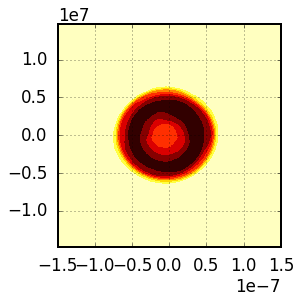

In [2]:
# variables saved in tomoXYZ_eval.dat files in order of line
long_eval_headers = [
    'matchedemittance', 'ninetyemittance', 'rmsemittance', 
    'statisticalemittance', 'bunchingfactor', 'fs0', 'fs1', 
    'eperimage', 'peakcurrent', 'peakdensity', 'sigmaE', 
    'deltap', 'bunchlength', 'dtbin', 'dEbin', 'phasespace',
]

c185_scope = 'PR_SCOPE57_CH01'
c1350_scope = 'PR_SCOPE58_CH01'

def extract_long_eval(ftime, ctime='185'):
    data = {}
    with open(ftime + '_tomo{ctime}_eval.dat'.format(ctime=ctime), 'r') as stream:
        for header in long_eval_headers[:-1]:
            data[header] = float(stream.readline())
    return data

def extract_long_phasespace(ftime, ctime='185'):
    with open(ftime + '_tomo{ctime}_eval.dat'.format(ctime=ctime), 'r') as stream:
        fcontent = stream.readlines()
    phasespace = fcontent[15][2:-2]
    phasespace = (phasespace.replace('}, {', '\n')
                            .replace('*^', 'e'))
    phasespace = StringIO(unicode(phasespace))
    return np.genfromtxt(phasespace, dtype=np.float64, delimiter=',')

def extract_deltap_profile(ftime, ctime='185'):
    profile = np.genfromtxt(ftime + '_tomo{ctime}_deltap.dat'.format(ctime=ctime), 
                            delimiter=',', dtype=np.float64, unpack=True)
    return profile

def extract_fildeltap_profile(ftime, ctime='185'):
    profile = np.genfromtxt(ftime + '_tomo{ctime}_fildeltap.dat'.format(ctime=ctime), 
                            delimiter=',', dtype=np.float64, unpack=True)
    return profile

def extract_intensities(myDataStruct, window_radius_ms=3):
    ctime = 185
    t_offset = myDataStruct.PR_BCT_ST.Samples.value.firstSampleTime
    lo, hi = (ctime - window_radius_ms - t_offset, 
              ctime + window_radius_ms - t_offset)
    intensity_185 = 1e10 * np.mean(myDataStruct.PR_BCT_ST.Samples.value.samples[lo:hi+1])
    ctime = 1350
    t_offset = myDataStruct.PR_BCT_ST.Samples.value.firstSampleTime
    lo, hi = (ctime - window_radius_ms - t_offset, 
              ctime + window_radius_ms - t_offset)
    intensity_1350 = 1e10 * np.mean(myDataStruct.PR_BCT_ST.Samples.value.samples[lo:hi+1])
    return intensity_185, intensity_1350

def extract_long_profile(myDataStruct_scopechannel):
    '''Return time position [in ns] and normalised profile [integrates to 1].'''
    dtbin = myDataStruct_scopechannel.Acquisition.value.sampleInterval 
    tomodata = myDataStruct_scopechannel.Acquisition.value.value
    tomotimes = np.arange(0, len(tomodata[0]) * dtbin, dtbin)
    tomo_reference = tomodata[0]
    baseline = np.mean(tomo_reference[:int(len(tomo_reference)*0.05)])
    tomoprofile = tomo_reference - baseline
    tomoprofile /= np.trapz(tomoprofile, tomotimes)

    return tomotimes, tomoprofile

def plot_longphasespace(ftime, ctime='185', ax=None,
                        *contourf_args, **contourf_kwargs):
    longdata = extract_long_eval(ftime, ctime)
    longdata['phasespace'] = extract_long_phasespace(ftime, ctime)
    elen, tlen = longdata['phasespace'].shape
    thalf = tlen*longdata['dtbin']/2.
    ehalf = elen*longdata['dEbin']/2.
    TT, EE = np.meshgrid(np.linspace(-thalf, thalf, tlen), 
                         np.linspace(-ehalf, ehalf, elen))
    if ax is None:
        ax = plt.gca()
    ax.contourf(TT, EE, longdata['phasespace'].T, origin='lower', 
                cmap=plt.get_cmap('hot_r'),
                *contourf_args, **contourf_kwargs)
    ax.set_aspect(thalf/ehalf)
    plt.grid(True)


plot_longphasespace('hollow_bunchlength_scan/2015.11.15.22.02.28.003')


def plot_c185_c1350_longphasespace(ftime):
    fig, axes = plt.subplots(1, 2, figsize=(11,5), sharex=True, sharey=True)

    plot_longphasespace(ftime[:-4], ctime=185, ax=axes[0])
    axes[0].set_title('C185')
    plot_longphasespace(ftime[:-4], ctime=1350, ax=axes[1])
    axes[1].set_title('C1350')

    for ax in axes:
        ax.grid(True)

def plot_c185_c1350(what, avg=True, fig=None):
    if fig:
        ax = plt.gcf(fig).axes
    else:
        fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
    plt.sca(ax[0])
    ax[0].set_title('C185')
    ax[0].plot(data_gauss[what][0], label='gauss')
    ax[0].plot(data_hollow[what][0], label='hollow')
    if avg:
        ax[0].axhline(np.mean(data_gauss[what][0]), c='b', ls='--')
        ax[0].axhline(np.mean(data_hollow[what][0]), c='g', ls='--')
    ax[0].grid(True)
    plt.legend()
    
    plt.sca(ax[1])
    ax[1].set_title('C1350')
    ax[1].plot(data_gauss[what][1], label='gauss')
    ax[1].plot(data_hollow[what][1], label='hollow')
    if avg:
        ax[1].axhline(np.mean(data_gauss[what][1]), c='b', ls='--')
        ax[1].axhline(np.mean(data_hollow[what][1]), c='g', ls='--')
    ax[1].grid(True)
    plt.legend()
    plt.suptitle(what, fontsize=18)
    plt.subplots_adjust(top=0.85)

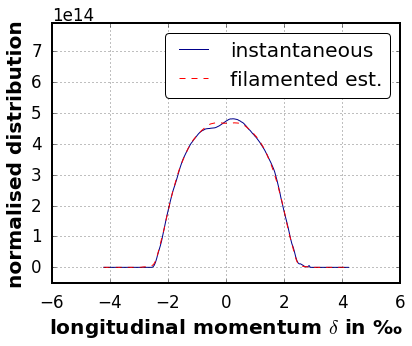

In [3]:
plt.figure(figsize=(6, 5))

ftime = 'hollow_bunchlength_scan/2015.11.15.21.02.39.977'
ctime = '185'

deltap_prof = extract_deltap_profile(ftime, ctime)
fildeltap_prof = extract_fildeltap_profile(ftime, ctime)

plt.plot(1e3*deltap_prof[0], deltap_prof[1], c='darkblue', label='instantaneous')
plt.plot(1e9*fildeltap_prof[0], 1e-6*fildeltap_prof[1], 
         c='red', ls='--', label='filamented est.')
plt.legend()
plt.grid(True)

plt.ylim(-0.5e14, 7.9e14)
plt.xlim(-6, 6)

plt.xlabel(u'longitudinal momentum $\delta$ in ‰')
plt.ylabel('normalised distribution')

plt.tight_layout()

plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/deltap_inst_fil.pdf')

In [4]:
def read_data(files):
    '''first entry of each value tuple is for C185, 
    the second is for C1350.
    '''
    data = {
        header: (np.empty(len(files), dtype=np.float64), 
                 np.empty(len(files), dtype=np.float64))
        for header in long_eval_headers[:-1] # leave out longitudinal phasespace
    }
    data.update({
        'bct': [],
        'losses': [],
        'intensity': ([], []),
        'h_position': ([], []),
        'h_profile': ([], []),
        'v_position': ([], []),
        'v_profile': ([], []),
        'dp_position': ([], []),
        'dp_profile': ([], []),
        'z_position': ([], []),
        'z_profile': ([], []),
        'v_bbq': [],
        'v_tune': [],
        'h_bbq': [],
        'h_tune': [],
    })
    for i, file_ in enumerate(files):
        ftime = file_[:-4]
        
        # general
        myDataStruct = loadmat(file_, squeeze_me=True, 
                               struct_as_record=False)['myDataStruct']
        data['bct'].append(myDataStruct.PR_BCT_ST.Samples.value.samples)
        n185, n1350 = extract_intensities(myDataStruct)
        data['intensity'][0].append(n185)
        data['intensity'][1].append(n1350)
        data['losses'].append((n185 - n1350) / n185)
        
        # longitudinal profiles
        for varname, value in extract_long_eval(ftime, ctime=185).iteritems():
            data[varname][0][i] = value
        for varname, value in extract_long_eval(ftime, ctime=1350).iteritems():
            data[varname][1][i] = value
#         dp_185_pos, dp_185_prof = extract_deltap_profile(ftime, ctime=185)
#         dp_1350_pos, dp_1350_prof = extract_deltap_profile(ftime, ctime=1350)
        # use synchrotron amplitude averaged distributions: (positions off by factor 1e6!)
        dp_185_pos, dp_185_prof = extract_fildeltap_profile(ftime, ctime=185)
        dp_1350_pos, dp_1350_prof = extract_fildeltap_profile(ftime, ctime=1350)
        data['dp_position'][0].append(1e6 * dp_185_pos)
        data['dp_position'][1].append(1e6 * dp_1350_pos)
        data['dp_profile'][0].append(dp_185_prof)
        data['dp_profile'][1].append(dp_1350_prof)
        z_185_pos, z_185_prof = extract_long_profile(getattr(myDataStruct, c185_scope))
        z_1350_pos, z_1350_prof = extract_long_profile(getattr(myDataStruct, c1350_scope))
        data['z_position'][0].append(z_185_pos)
        data['z_position'][1].append(z_1350_pos)
        data['z_profile'][0].append(z_185_prof)
        data['z_profile'][1].append(z_1350_prof)
                                     
        # transverse profiles
        h_rot_value = myDataStruct.PR_BWS_54_H_ROT.Logging.value
        v_rot_value = myDataStruct.PR_BWS_85_V_ROT.Logging.value
        data['h_position'][0].append(h_rot_value.projPositionSet1)
        data['h_position'][1].append(h_rot_value.projPositionSet2)
        data['h_profile'][0].append(h_rot_value.projDataSet1)
        data['h_profile'][1].append(h_rot_value.projDataSet2)
        data['v_position'][0].append(v_rot_value.projPositionSet1)
        data['v_position'][1].append(v_rot_value.projPositionSet2)
        data['v_profile'][0].append(v_rot_value.projDataSet1)
        data['v_profile'][1].append(v_rot_value.projDataSet2)
        
        # tunes
        data['v_bbq'].append(myDataStruct.PR_BQS72.Acquisition.value.rawDataV)
        fft_data = np.abs(np.fft.rfft(data['v_bbq'][-1][256:1024+256]))
        v_tune = (0.5 - 1/(2.*len(fft_data))) * np.argmax(fft_data) / len(fft_data)
        data['v_tune'].append(v_tune)
        data['h_bbq'].append(myDataStruct.PR_BQS72.Acquisition.value.rawDataH)
        fft_data = np.abs(np.fft.rfft(data['h_bbq'][-1][256:1024+256]))
        h_tune = (0.5 - 1/(2.*len(fft_data))) * np.argmax(fft_data) / len(fft_data)
        data['h_tune'].append(h_tune)
        
        sys.stdout.write(
            '\r*** treated {0} out of {1} files'.format(i + 1, len(files))
        )
        sys.stdout.flush()
    print ('\n')
    return data

# for transverse emittances
def gauss(x, ampl, mu, sigma):
    '''Args: evaluation position, amplitude, mean, sigma'''
    return ampl * np.exp(-(x - mu)**2 / (2. * sigma**2))

def fit_gauss(position, profile,
        init_guess=[1., 0., 3e-3], # amplitude, mean [m], sigma [m]
        core_sigma=1.8, halo_sigma=4, halo_fit=False):
    baseline = np.median(profile)
    
    (fit_ampl_pre, fit_mu_pre, fit_sigma_pre), var_matrix_pre = \
        curve_fit(gauss, position, profile - baseline, p0=init_guess)

    core_ids = np.where(np.abs(position - fit_mu_pre) < core_sigma * fit_sigma_pre)[0]
    halo_ids = np.where((np.abs(position - fit_mu_pre) < halo_sigma * fit_sigma_pre) & 
                        (np.abs(position - fit_mu_pre) >= core_sigma * fit_sigma_pre))[0]


    lbound, ubound = halo_ids[[0,-1]]
    pos_uptohalo = np.array(position[lbound:ubound+1])
    prof_uptohalo = np.array(profile[lbound:ubound+1]) - baseline
    prof_uptohalo /= np.trapz(prof_uptohalo, pos_uptohalo)
    
    std = np.sqrt(np.trapz(pos_uptohalo**2 * prof_uptohalo, pos_uptohalo))
    
    (fit_ampl_core, fit_mu_core, fit_sigma_core), var_matrix_core = \
        curve_fit(gauss, position[core_ids], profile[core_ids] - baseline, 
                  p0=(fit_ampl_pre, fit_mu_pre, fit_sigma_pre))

    fit_sigma_relerr = np.abs(fit_sigma_core - fit_sigma_pre) / fit_sigma_core
    if fit_sigma_relerr >= 0.05:
        print ('*** WARNING: significant relative change of sigma between '
               'the pre-fit of the whole wire scan, sigma_pre={pre},'
               'and the subsequent core fit, sigma_core={core}'.format(
                   pre=fit_sigma_pre, core=fit_sigma_core))

    fit_quantities = {
        'baseline': baseline, 
        'std': std,
        'fit_ampl_pre': fit_ampl_pre, 
        'fit_mu_pre': fit_mu_pre, 
        'fit_sigma_pre': fit_sigma_pre, 
        'var_matrix_pre': var_matrix_pre,
        'core_ids': core_ids, 'halo_ids': halo_ids,
        'fit_ampl_core': fit_ampl_core, 
        'fit_mu_core': fit_mu_core, 
        'fit_sigma_core': fit_sigma_core, 
        'var_matrix_core': var_matrix_core,
        'fit_sigma_relerr': fit_sigma_relerr,
        'core_sigma': core_sigma,
    }

    if halo_fit:
        (fit_ampl_halo, fit_mu_halo, fit_sigma_halo), var_matrix_halo = \
            curve_fit(gauss, position[halo_ids], profile[halo_ids] - baseline, 
                      p0=(fit_ampl_pre, fit_mu_pre, fit_sigma_pre))
        fit_quantities.update({
                'fit_ampl_halo': fit_ampl_halo, 
                'fit_mu_halo': fit_mu_halo, 
                'fit_sigma_halo': fit_sigma_halo, 
                'var_matrix_halo': var_matrix_halo,
                'halo_sigma': halo_sigma,
            })

    return fit_quantities
            
def make_fiterror_function(x, disp_profile, x_profile):
    '''Arguments:
        x: 1D array with regularly spaced positions
        disp_profile: 1D array with dispersive profile D_x * delta along x
        x_profile: 1D array with measured horizontal profile from wire scanner
    '''
    def fiterror_function(sigma):
        '''Arguments:
            sigma: standard deviation of assumed Gaussian distribution
        '''
        betatron_profile = np.exp(-x**2 / (2*sigma**2))
        betatron_profile /= np.trapz(betatron_profile, x)
        dx = x[1] - x[0]
        
        x_profile_estimate = np.convolve(betatron_profile, disp_profile, 'same') * dx
        return x_profile - x_profile_estimate
    return fiterror_function

def get_v_emit_geo(data, data_idx, ctime_idx=0, beta_y=11.83):
    '''beta_y for PS 85.V is 11.83m'''
    pos = 1e-6 * data['v_position'][ctime_idx][data_idx]
    prof = data['v_profile'][ctime_idx][data_idx]
    fit_quantities = fit_gauss(pos, prof)
    return fit_quantities['fit_sigma_core']**2 / beta_y, fit_quantities

def get_h_emit_geo(data, data_idx, ctime_idx=0, 
                   beta_x=12.62, disp_x=2.3,
                   n_interp_points=1000, 
                   savgol_window=7, savgol_order=1):
    '''beta_x for PS 54.H is 12.62m, the disp_x is 2.3m, correspondingly.'''
    pos = 1e-6 * data['h_position'][ctime_idx][data_idx]
    if ctime_idx == 1:
        # wire scanner is going backwards
        pos *= -1
    prof = data['h_profile'][ctime_idx][data_idx]
    disp_pos = disp_x * data['dp_position'][ctime_idx][data_idx]
    disp_prof = data['dp_profile'][ctime_idx][data_idx] / disp_x

    inner_window = (max(np.amin(disp_pos), np.amin(pos)),
                    min(np.amax(disp_pos), np.amax(pos)))
    
    fit_quantities = fit_gauss(pos, prof)
    
    interp_pos = np.linspace(*inner_window, num=n_interp_points)
    interp_prof = np.interp(
        interp_pos, pos - fit_quantities['fit_mu_core'], 
        prof - fit_quantities['baseline'])
    interp_fprof = savgol_filter(
        interp_prof, savgol_window, savgol_order)
    interp_disp_prof = np.interp(interp_pos, disp_pos, disp_prof)
    
    interp_fprof /= np.trapz(interp_fprof, interp_pos)
    interp_disp_prof /= np.trapz(interp_disp_prof, interp_pos)
    
    fiterror_func = make_fiterror_function(
        x=interp_pos, disp_profile=interp_disp_prof, 
        x_profile=interp_fprof
    )

    sigma_betatron = scipy.optimize.leastsq(
        fiterror_func, fit_quantities['fit_sigma_core'])[0][0]
    return sigma_betatron**2 / beta_x, fit_quantities

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy.stats import norm

def fit_with_ci(xdata, ydata, ytobefit, conf_level_sigma=1,
                verbose_results=False, add_constant=False):
    '''Calculate fit and confidence intervals for an ordinary linear 
    regression model.
    Arguments:
        xdata: independent variable data
        ydata: dependent variable data
        ytobefit: tuple with entries for each functional dependency,
            e.g. (xdata, xdata**2, np.sin(xdata))
        conf_level_sigma: number of normal sigma for confidence level
            e.g. 1 corresponds to 68.3%, 2 corresponds to 95.4% c.l.
        verbose_results: prints regression results
        add_constant: adds a variable constant to the fit model
    Return 5-tuple of sorted xdata, fitted ydata and respective 
    lower and upper confidence level values, and finally the 
    statsmodels model fit results object.
    '''
    perm = np.argsort(xdata)
    # separate tuple entries for each functional dependency:
    X = np.column_stack(ytobefit)
    if add_constant:
        X = sm.add_constant(X)
    model = sm.OLS(ydata, X)
    results = model.fit()
    if verbose_results:
        print (results.summary())
    
    alpha = 1 - (norm.cdf(conf_level_sigma) - norm.cdf(-conf_level_sigma))
    # Calculate confidence interval lines
    prstd, iv_l, iv_u = wls_prediction_std(results, alpha=alpha)
    return (xdata[perm], results.fittedvalues[perm], 
            iv_l[perm], iv_u[perm], results)

# 1. Bunch Length Scan

In [177]:
wdir_gauss = 'Gauss_bunchlength_scan/'
wdir_hollow = 'hollow_bunchlength_scan/'

files_gauss = sorted(glob.glob(wdir_gauss + '*.mat'))
files_hollow = sorted(glob.glob(wdir_hollow + '*.mat'))

# bad files:
bad_files = [
    'Gauss_bunchlength_scan/2015.11.15.16.30.05.171.mat', # bad longitudinal distribution
    'Gauss_bunchlength_scan/2015.11.15.17.19.59.094.mat', # bad longitudinal distribution
    'Gauss_bunchlength_scan/2015.11.15.16.08.56.744.mat', # sort of bad longitudinal distribution
    'hollow_bunchlength_scan/2015.11.15.21.58.34.953.mat', # bad longitudinal distribution, shrinks ~0.93 factor
    'Gauss_bunchlength_scan/2015.11.15.17.57.49.335.mat', # BCT shows losses
    'hollow_bunchlength_scan/2015.11.15.21.23.45.950.mat', # BCT shows losses
    'hollow_bunchlength_scan/2015.11.15.21.26.44.784.mat', # BCT quite low intensity
    'hollow_bunchlength_scan/2015.11.15.21.10.01.413.mat', # too long bunch length
    'hollow_bunchlength_scan/2015.11.15.21.11.15.938.mat', # too long bunch length
]
files_gauss =  [f for f in files_gauss  if f not in bad_files]
files_hollow = [f for f in files_hollow if f not in bad_files]

data_gauss = read_data(files_gauss)
data_hollow = read_data(files_hollow)

*** treated 164 out of 164 files

*** treated 139 out of 139 files



### plot typical cases

In [178]:
files_gauss.index([f for f in files_gauss if '2015.11.15.16.07.14.567.mat' in f][0])

3

In [179]:
files_hollow.index([f for f in files_hollow if '2015.11.15.21.03.59.135.mat' in f][0])

7

In [180]:
from scipy.signal import savgol_filter

In [187]:
to_z = -1e-9*0.91596100835091632*c

repr_gauss_z = data_gauss['z_position'][0][3][718:2533] * to_z
repr_gauss_p = savgol_filter(data_gauss['z_profile'][0][3], 25, 1)[718:2533]
repr_gauss_p /= np.abs(np.trapz(repr_gauss_p, repr_gauss_z))

repr_hollow_z = data_hollow['z_position'][0][7][669:2461] * to_z
repr_hollow_p = savgol_filter(data_hollow['z_profile'][0][7], 25, 1)[669:2461]
repr_hollow_p /= np.abs(np.trapz(repr_hollow_p, repr_hollow_z))

repr_bl = data_gauss['bunchlength'][0][3] * np.abs(to_z)
repr_gaussampl = 1/(np.sqrt(2*np.pi)*repr_bl/4)
repr_mu = -np.trapz(repr_hollow_p*repr_hollow_z, repr_hollow_z)
repr_z = np.linspace(-150, 150, 100) * to_z
repr_rectampl = np.zeros_like(repr_z)
repr_rectampl[(-repr_bl/2 < repr_z) & (repr_z < repr_bl/2)] = 1/repr_bl

to_lambda_max = 0.028 / np.max(repr_gauss_p) * 100
repr_gauss_p *= to_lambda_max
repr_hollow_p *= to_lambda_max
repr_gaussampl *= to_lambda_max
repr_rectampl *= to_lambda_max

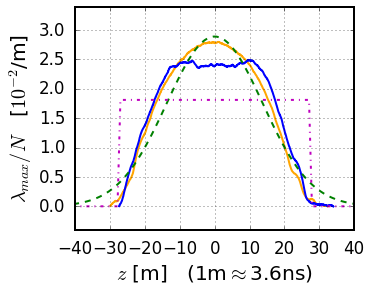

In [200]:
plt.figure(figsize=(5,4))
plt.plot(repr_gauss_z - repr_mu, repr_gauss_p, color='orange', lw=2, label='parabolic')
plt.plot(repr_hollow_z - repr_mu, repr_hollow_p, color='blue', lw=2, label='hollow')
plt.ylim(-0.4, 3.4)
plt.xlim(-40, 40)
plt.grid()
plt.xlabel(r'$z$ [m]   (1m$\approx$3.6ns)', fontweight='normal')
plt.ylabel('$\lambda_{max}/N$   [$10^{-2}$/m]', fontweight='normal')
plt.savefig('ex_profiles1.pdf', bbox_inches='tight')
plt.plot(repr_z, gauss(repr_z, repr_gaussampl, 0, repr_bl/4), 'g--', lw=2, label='')
plt.plot(repr_z, repr_rectampl, 'm-.', lw=2, label='')
plt.savefig('ex_profiles2.pdf', bbox_inches='tight')

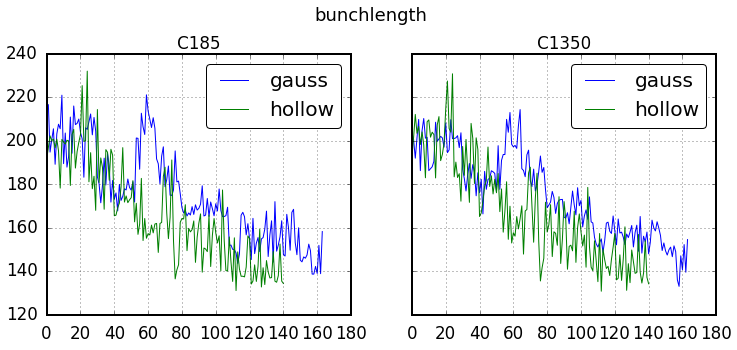

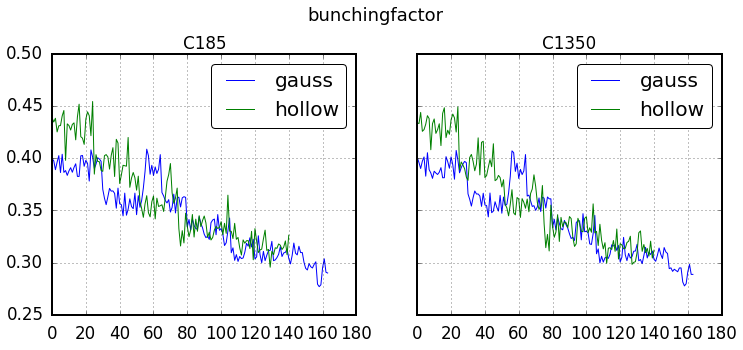

In [5]:
plot_c185_c1350('bunchlength', False)
plot_c185_c1350('bunchingfactor', False)

### the bunch lengths are equivalent while the longitudinal RMS emittance is larger for the hollow bunches:

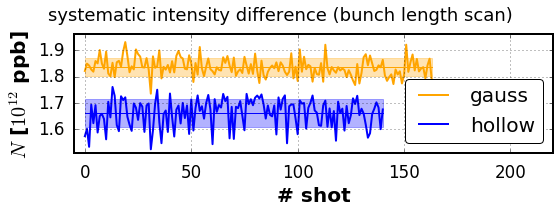

In [196]:
plt.figure(figsize=(8,3))

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    np.arange(len(files_gauss)), 1e-12*np.array(data_gauss['intensity'][0]), 
    (np.ones(len(files_gauss)),), conf_level_sigma=1, add_constant=False)
plt.plot(xdata_h, yfit_h, c='orange')
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='orange', alpha=0.3)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    np.arange(len(files_hollow)), 1e-12*np.array(data_hollow['intensity'][0]), 
    (np.ones(len(files_hollow)),), conf_level_sigma=1, add_constant=False)
plt.plot(xdata_g, yfit_g, c='blue')
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='blue', alpha=0.3)

plt.plot(1e-12*np.array(data_gauss['intensity'][0]), c='orange', lw=2, label='gauss')
plt.plot(1e-12*np.array(data_hollow['intensity'][0]), c='blue', lw=2, label='hollow')

plt.grid(True)
plt.xlim(-5, 220)
plt.ylim(1.51, 1.96)
plt.legend(loc=4)
plt.xlabel('# shot')
plt.ylabel('$N$ [$10^{12}$ ppb]')

plt.tight_layout()

plt.subplots_adjust(top=0.85)
plt.suptitle('systematic intensity difference (bunch length scan)', fontsize=18)

plt.savefig('/home/oeftiger/cern/documents/latex/16-03-04--MSWG-hollow-bunches/'
            'images/intensities.pdf', bbox_inches='tight')

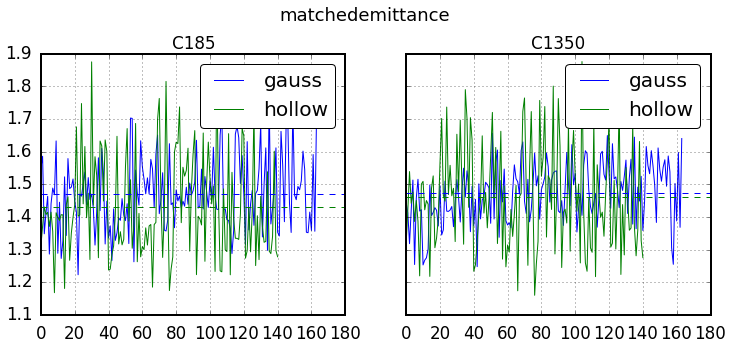

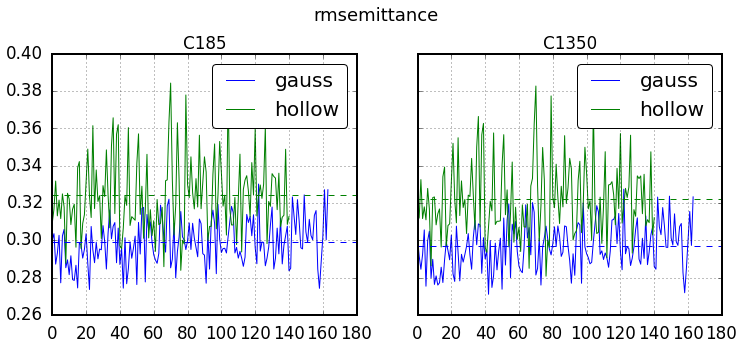

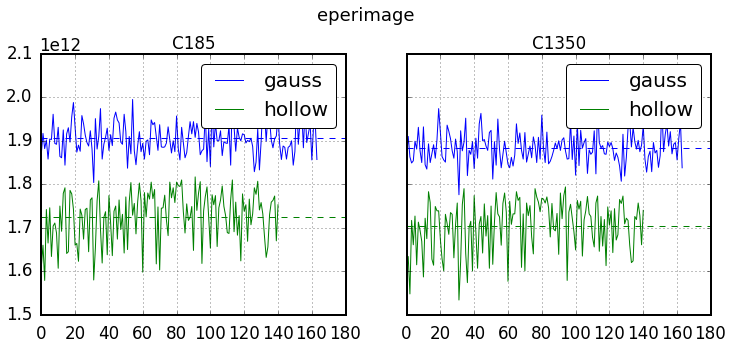

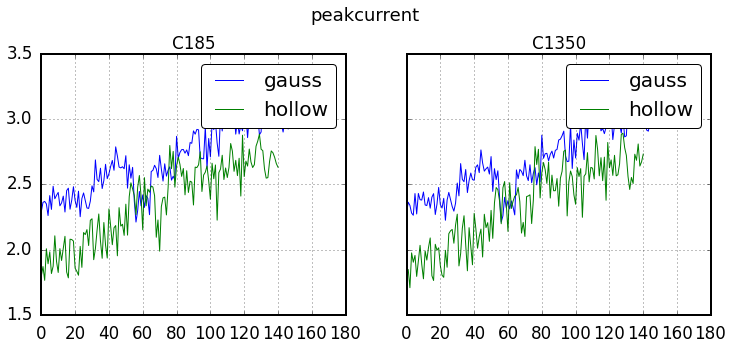

In [6]:
plot_c185_c1350('matchedemittance', True)
plot_c185_c1350('rmsemittance', True)
plot_c185_c1350('eperimage', True)
plot_c185_c1350('peakcurrent', False)

In [421]:
print ("Gauss  longitudinal RMS emittance  C185: ",
       np.mean(data_gauss['rmsemittance'][0]),
       "+-",
       np.std(data_gauss['rmsemittance'][0]))
print ("Gauss  longitudinal RMS emittance C1350: ",
       np.mean(data_gauss['rmsemittance'][1]),
       "+-",
       np.std(data_gauss['rmsemittance'][1]))
print ("Hollow longitudinal RMS emittance  C185: ",
       np.mean(data_hollow['rmsemittance'][0]),
       "+-",
       np.std(data_hollow['rmsemittance'][0]))
print ("Hollow longitudinal RMS emittance C1350: ",
       np.mean(data_hollow['rmsemittance'][1]),
       "+-",
       np.std(data_hollow['rmsemittance'][1]))

print ("Gauss  longitudinal matched emittance  C185: ",
       np.mean(data_gauss['matchedemittance'][0]),
       "+-",
       np.std(data_gauss['rmsemittance'][0]))
print ("Gauss  longitudinal matched emittance C1350: ",
       np.mean(data_gauss['matchedemittance'][1]),
       "+-",
       np.std(data_gauss['matchedemittance'][1]))
print ("Hollow longitudinal matched emittance  C185: ",
       np.mean(data_hollow['matchedemittance'][0]),
       "+-",
       np.std(data_hollow['matchedemittance'][0]))
print ("Hollow longitudinal matched emittance C1350: ",
       np.mean(data_hollow['matchedemittance'][1]),
       "+-",
       np.std(data_hollow['matchedemittance'][1]))

print ("")

print ("Hollow / Gauss longitudinal RMS emittance C1350:",
       np.mean(data_hollow['rmsemittance'][1]) /
       np.mean(data_gauss['rmsemittance'][1]),
       "+-",
       np.sqrt(
           np.std(data_hollow['rmsemittance'][1])**2 /
           np.mean(data_gauss['rmsemittance'][1]) +
           np.mean(data_hollow['rmsemittance'][1]) *
           np.std(data_hollow['rmsemittance'][1])**2 /
           np.mean(data_gauss['rmsemittance'][1])**2
       ))
print ("Hollow / Gauss longitudinal matched emittance C1350:",
       np.mean(data_hollow['matchedemittance'][1]) /
       np.mean(data_gauss['matchedemittance'][1]),
       "+-",
       np.sqrt(
           np.std(data_hollow['matchedemittance'][1])**2 /
           np.mean(data_gauss['matchedemittance'][1]) +
           np.mean(data_hollow['matchedemittance'][1]) *
           np.std(data_hollow['matchedemittance'][1])**2 /
           np.mean(data_gauss['matchedemittance'][1])**2
       ))

Gauss  longitudinal RMS emittance  C185:  0.298898193515 +- 0.0122814644407
Gauss  longitudinal RMS emittance C1350:  0.296649328583 +- 0.0122387433936
Hollow longitudinal RMS emittance  C185:  0.324058639661 +- 0.0199248480865
Hollow longitudinal RMS emittance C1350:  0.321960489552 +- 0.0196973888325
Gauss  longitudinal matched emittance  C185:  1.47146198165 +- 0.0122814644407
Gauss  longitudinal matched emittance C1350:  1.4724877314 +- 0.0891897606924
Hollow longitudinal matched emittance  C185:  1.42932849314 +- 0.154041990625
Hollow longitudinal matched emittance C1350:  1.46061859437 +- 0.156281506584

Hollow / Gauss longitudinal RMS emittance C1350: 1.08532350668 +- 0.0522244280818
Hollow / Gauss longitudinal matched emittance C1350: 0.991939398351 +- 0.181768995642


## blowup of longitudinal emittances

### checking good shots:

Indices with longitudinal RMS emittance blowup outside of 5% range: 
Gaussian distribution:  []
Hollow distribution:    []


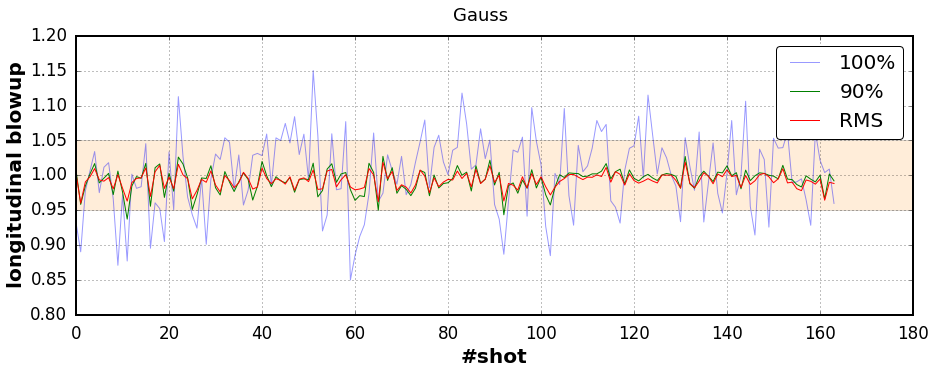

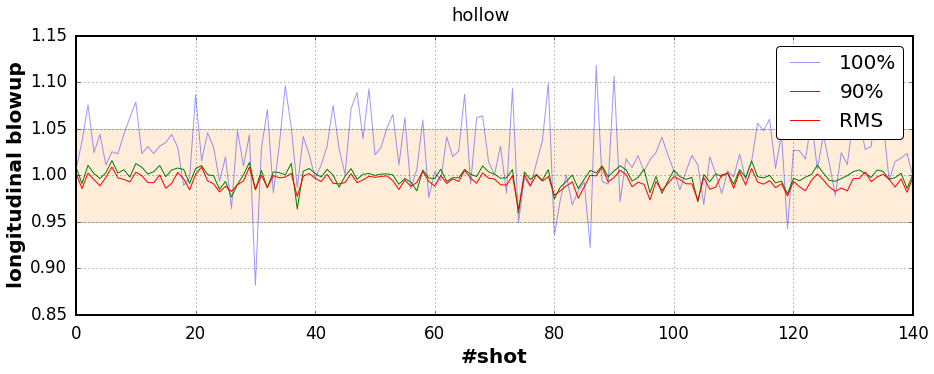

In [7]:
gauss_matchedemit_blowup = (data_gauss['matchedemittance'][1] 
                            / data_gauss['matchedemittance'][0])
gauss_ninetyemit_blowup = (data_gauss['ninetyemittance'][1] 
                           / data_gauss['ninetyemittance'][0])
gauss_rmsemit_blowup = (data_gauss['rmsemittance'][1] 
                        / data_gauss['rmsemittance'][0])

hollow_matchedemit_blowup = (data_hollow['matchedemittance'][1] 
                            / data_hollow['matchedemittance'][0])
hollow_ninetyemit_blowup = (data_hollow['ninetyemittance'][1] 
                           / data_hollow['ninetyemittance'][0])
hollow_rmsemit_blowup = (data_hollow['rmsemittance'][1] 
                        / data_hollow['rmsemittance'][0])

bad_gauss_ids = np.where(np.abs(1 - gauss_rmsemit_blowup) > 0.05)[0]
bad_hollow_ids = np.where(np.abs(1 - hollow_rmsemit_blowup) > 0.05)[0]

plt.figure(figsize=(15,5))
plt.plot(gauss_matchedemit_blowup, alpha=0.4, label='100%')
plt.plot(gauss_ninetyemit_blowup, label='90%')
plt.plot(gauss_rmsemit_blowup, label='RMS')
plt.fill_between(plt.xlim(), 0.95, 1.05, facecolor='darkorange', alpha=0.15)
plt.legend()
plt.grid(True)
plt.xlabel('#shot')
plt.ylabel('longitudinal blowup')
plt.suptitle('Gauss', fontsize=18)

plt.figure(figsize=(15,5))
plt.plot(hollow_matchedemit_blowup, alpha=0.4, label='100%')
plt.plot(hollow_ninetyemit_blowup, label='90%')
plt.plot(hollow_rmsemit_blowup, label='RMS')
plt.fill_between(plt.xlim(), 0.95, 1.05, facecolor='darkorange', alpha=0.15)
plt.legend()
plt.grid(True)
plt.xlabel('#shot')
plt.ylabel('longitudinal blowup')
plt.suptitle('hollow', fontsize=18)

print ('Indices with longitudinal RMS emittance blowup outside of 5% range: ')
print ('Gaussian distribution: ', bad_gauss_ids)
print ('Hollow distribution:   ', bad_hollow_ids)

comparing the longitudinal profiles between C185 and C1350 (via plot_c185_c1350_longphasespace), 
some shots need to be removed because their longitudinal emittances vary too much.

Among them are:
- Gauss_bunchlength_scan/2015.11.15.16.30.05.171.mat
- Gauss_bunchlength_scan/2015.11.15.17.19.59.094.mat
- Gauss_bunchlength_scan/2015.11.15.16.08.56.744.mat
- hollow_bunchlength_scan/2015.11.15.21.58.34.953.mat

## transverse emittance blowup

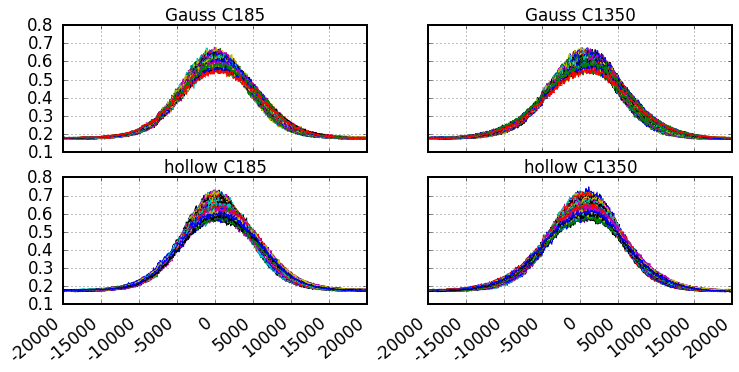

In [8]:
plane = 'h'
fig, ax = plt.subplots(2, 2, figsize=(12,5), sharex=True, sharey=True)
for pos, profile in zip(data_gauss[plane + '_position'][0], data_gauss[plane + '_profile'][0]):
    ax[0,0].plot(pos, profile)
ax[0,0].set_title('Gauss C185')
for pos, profile in zip(data_gauss[plane + '_position'][1], data_gauss[plane + '_profile'][1]):
    ax[0,1].plot(pos, profile)
ax[0,1].set_title('Gauss C1350')
for pos, profile in zip(data_hollow[plane + '_position'][0], data_hollow[plane + '_profile'][0]):
    ax[1,0].plot(pos, profile)
ax[1,0].set_title('hollow C185')
for pos, profile in zip(data_hollow[plane + '_position'][1], data_hollow[plane + '_profile'][1]):
    ax[1,1].plot(pos, profile)
ax[1,1].set_title('hollow C1350')
plt.xlim((-2e4, 2e4))
plt.ylim((0.1, 0.8))

for axis in np.ravel(ax):
    axis.grid(True)
    axis.set_xticklabels(axis.get_xticks().astype(int), rotation=40, ha='right')

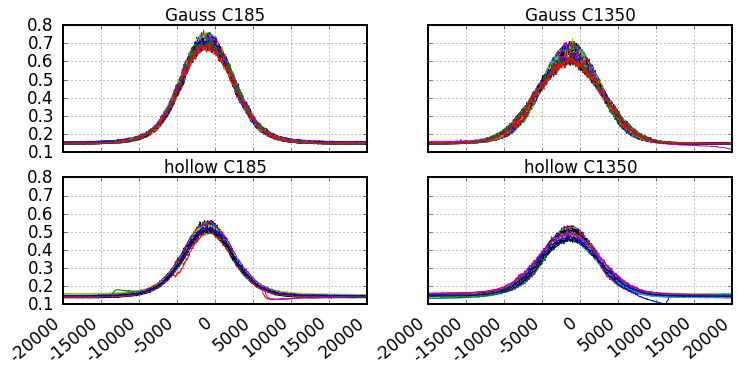

In [9]:
plane = 'v'
fig, ax = plt.subplots(2, 2, figsize=(12,5), sharex=True, sharey=True)
for pos, profile in zip(data_gauss[plane + '_position'][0], data_gauss[plane + '_profile'][0]):
    ax[0,0].plot(pos, profile)
ax[0,0].set_title('Gauss C185')
for pos, profile in zip(data_gauss[plane + '_position'][1], data_gauss[plane + '_profile'][1]):
    ax[0,1].plot(pos, profile)
ax[0,1].set_title('Gauss C1350')
for pos, profile in zip(data_hollow[plane + '_position'][0], data_hollow[plane + '_profile'][0]):
    ax[1,0].plot(pos, profile)
ax[1,0].set_title('hollow C185')
for pos, profile in zip(data_hollow[plane + '_position'][1], data_hollow[plane + '_profile'][1]):
    ax[1,1].plot(pos, profile)
ax[1,1].set_title('hollow C1350')
plt.xlim((-2e4, 2e4))
plt.ylim((0.1, 0.8))

for axis in np.ravel(ax):
    axis.grid(True)
    axis.set_xticklabels(axis.get_xticks().astype(int), rotation=40, ha='right')

### individual wire scans, some introspection

#### vertical

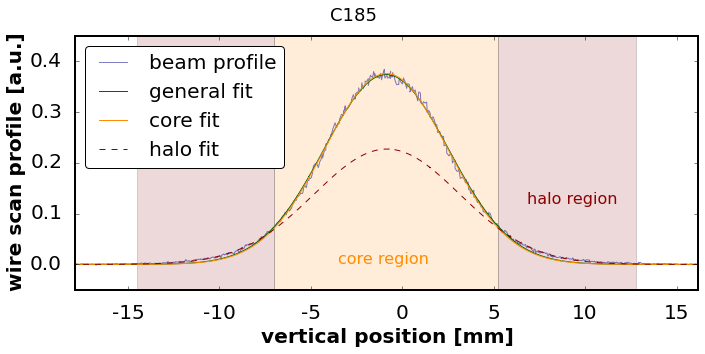

In [402]:
l_core_sigma = 1.8
l_halo_sigma = 4

plt.figure(figsize=(10, 5))

pos = 1e-6 * data_hollow['v_position'][0][-1]
prof = data_hollow['v_profile'][0][-1]
fit_quantities = fit_gauss(pos, prof, core_sigma=l_core_sigma, 
                           halo_sigma=l_halo_sigma, halo_fit=True)
globals().update(fit_quantities)

plt.plot(pos*1e3, prof - baseline, c='darkblue', alpha=0.5,
        label='beam profile')
plt.plot(pos*1e3, gauss(pos, fit_ampl_pre, fit_mu_pre, fit_sigma_pre), 
         c='darkgreen', label='general fit')
plt.plot(pos*1e3, gauss(pos, fit_ampl_core, fit_mu_core, fit_sigma_core), 
         c='darkorange', label='core fit')
plt.plot(pos*1e3, gauss(pos, fit_ampl_halo, fit_mu_halo, fit_sigma_halo), 
         c='darkred', ls='--', label='halo fit')
ylims = plt.ylim(-0.05, 0.45)

core_lbound = fit_mu_pre - l_core_sigma * fit_sigma_pre
core_ubound = fit_mu_pre + l_core_sigma * fit_sigma_pre
halo_lbound = fit_mu_pre - l_halo_sigma * fit_sigma_pre
halo_ubound = fit_mu_pre + l_halo_sigma * fit_sigma_pre

plt.fill_betweenx(ylims, core_lbound*1e3, core_ubound*1e3, facecolor='darkorange', alpha=0.15)
plt.fill_betweenx(ylims, halo_lbound*1e3, core_lbound*1e3, facecolor='darkred', alpha=0.15)
plt.fill_betweenx(ylims, core_ubound*1e3, halo_ubound*1e3, facecolor='darkred', alpha=0.15)

plt.text(6.8, 0.12, 'halo region', color='darkred', fontsize=16)
plt.text(-3.5, 0.0, 'core region', color='darkorange', fontsize=16)
# plt.text(7, 0.12, 'halo region', color='darkred', fontsize=16)
# plt.text(-5, 0.0, 'core region', color='darkorange', fontsize=16)

plt.xlim((halo_lbound*1e3 - fit_sigma_pre*1e3, halo_ubound*1e3 + fit_sigma_pre*1e3))
plt.ylim(ylims)

# plt.grid(True)
plt.xlabel('vertical position [mm]')
plt.ylabel('wire scan profile [a.u.]')

plt.legend(loc=2)

from matplotlib.ticker import FuncFormatter
plt.gca().get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: int(x)))

# plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right');

plt.tight_layout()

plt.subplots_adjust(top=0.9)
plt.suptitle('C185', fontsize=18)

plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/vert_ws_c185.pdf')

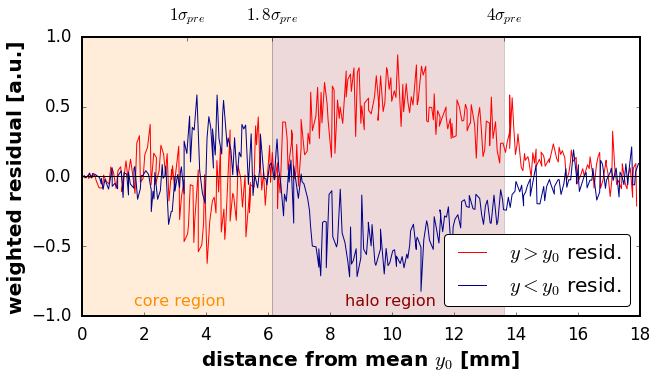

In [335]:
pos_minus_idx = np.where((-18e-3 <= pos - fit_mu_pre) & (pos - fit_mu_pre <= 0))
pos_plus_idx = np.where((0 <= pos - fit_mu_pre) & (pos - fit_mu_pre <= 18e-3))

plt.figure(figsize=(10, 5))

plusline, = plt.plot(
    np.abs((pos[pos_plus_idx] - fit_mu_pre) * 1e3), 
    -((gauss(pos, fit_ampl_pre, fit_mu_pre, fit_sigma_pre) - 
       (prof - baseline)) * np.abs(pos - fit_mu_pre))[pos_plus_idx] * 1e4,
    color='red', 
)
minusline, = plt.plot(
    np.abs((pos[pos_minus_idx] - fit_mu_pre) * 1e3), 
    ((gauss(pos, fit_ampl_pre, fit_mu_pre, fit_sigma_pre) - 
      (prof - baseline)) * np.abs(pos - fit_mu_pre))[pos_minus_idx] * 1e4,
    color='darkblue', label='negative residual'
)

ylims = plt.ylim()

plt.fill_betweenx(ylims, 0, 
                  (core_ubound - fit_mu_pre)*1e3, facecolor='darkorange', alpha=0.15)
plt.fill_betweenx(ylims, (core_ubound - fit_mu_pre)*1e3, 
                  (halo_ubound - fit_mu_pre)*1e3, facecolor='darkred', alpha=0.15)

plt.axhline(0, c='black')

plt.text(8.5, -0.93, 'halo region', color='darkred', fontsize=16)
plt.text(1.7, -0.93, 'core region', color='darkorange', fontsize=16)

ax = plt.gca()
plt.xlabel('distance from mean $y_0$ [mm]')
plt.ylabel('weighted residual [a.u.]')

plt.legend((plusline, minusline), ('$y>y_0$ resid.', '$y<y_0$ resid.'), 
           loc=4)
           #bbox_to_anchor=(1.1, 0.3));

plt.twiny().set_xticks(ax.get_xticks())
plt.gca().set_xticks(
    [fit_sigma_pre*1e3, fit_sigma_pre*1.8*1e3, fit_sigma_pre*4*1e3],
)
plt.gca().set_xticklabels(
    ['$1\sigma_{pre}$', '$1.8\sigma_{pre}$', '$4\sigma_{pre}$']
);

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/vert_ws_regions.pdf')

In [386]:
data_tbp.shape

(2411,)

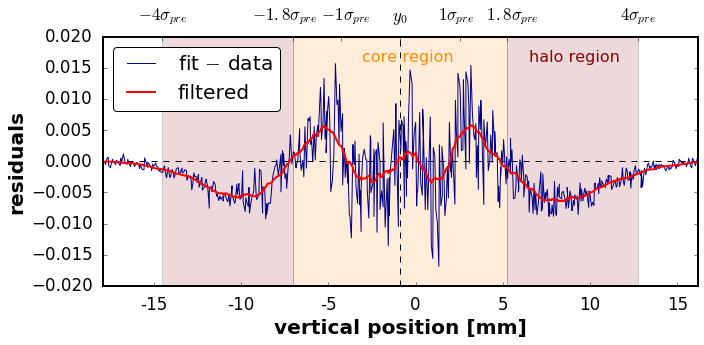

In [413]:
from scipy.signal import savgol_filter

plt.figure(figsize=(10, 5))

data_tbp = (gauss(pos, fit_ampl_pre, fit_mu_pre, fit_sigma_pre)
                  - (prof - baseline)) #4 * np.abs(pos - fit_mu_pre)

plt.plot(pos*1e3, data_tbp, c='darkblue', zorder=3, label='fit $-$ data')

plt.plot(pos*1e3, savgol_filter(data_tbp, 31, 1), 
         c='red', zorder=3, label='filtered', lw=2)

ylims = plt.ylim()

plt.fill_betweenx(ylims, core_lbound*1e3, core_ubound*1e3, facecolor='darkorange', alpha=0.15)
plt.fill_betweenx(ylims, halo_lbound*1e3, core_lbound*1e3, facecolor='darkred', alpha=0.15)
plt.fill_betweenx(ylims, core_ubound*1e3, halo_ubound*1e3, facecolor='darkred', alpha=0.15)

plt.xlim((halo_lbound*1e3 - fit_sigma_pre*1e3, halo_ubound*1e3 + fit_sigma_pre*1e3))
plt.ylim(ylims)

plt.axhline(0, c='black', ls='--')
plt.axvline(fit_mu_pre*1e3, c='black', ls='--')

# plt.grid(True)
plt.xlabel('vertical position [mm]')
plt.ylabel('residuals')

plt.legend(loc=2)

from matplotlib.ticker import FuncFormatter
ax = plt.gca()
ax.get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: int(x)))

plt.twiny().set_xlim(ax.get_xlim())
plt.gca().set_xticks(
    [halo_lbound*1e3,
     core_lbound*1e3,
     (-fit_sigma_pre + fit_mu_pre)*1e3,
     (fit_mu_pre)*1e3,
     (fit_sigma_pre + fit_mu_pre)*1e3,
     core_ubound*1e3,
     halo_ubound*1e3],
)
plt.gca().set_xticklabels(
    ['$-4\sigma_{pre}$', r'$-1.8\sigma_{pre}$    ',
     r'  $-1\sigma_{pre}$', '$y_0$',
     r'$1\sigma_{pre}$  ',
     r'  $1.8\sigma_{pre}$', '$4\sigma_{pre}$'],
);

# plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right');

plt.text(6.5, 0.016, 'halo region', color='darkred', fontsize=16)
plt.text(-3.05, 0.016, 'core region', color='darkorange', fontsize=16)

plt.tight_layout()

plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/vert_ws_regions.pdf', bbox_inches='tight')

#### horizontal (dispersion!!!)

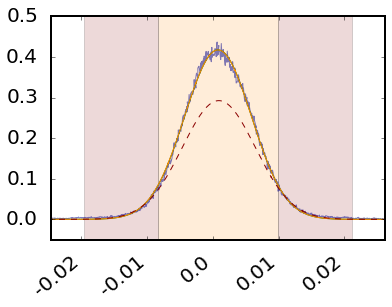

In [396]:
pos = 1e-6 * data_hollow['h_position'][0][-2]
prof = data_hollow['h_profile'][0][-2]
fit_quantities = fit_gauss(pos, prof, core_sigma=l_core_sigma, 
                           halo_sigma=l_halo_sigma, halo_fit=True)
globals().update(fit_quantities)

plt.plot(pos, prof - baseline, c='darkblue', alpha=0.5)
plt.plot(pos, gauss(pos, fit_ampl_pre, fit_mu_pre, fit_sigma_pre), c='darkgreen')
plt.plot(pos, gauss(pos, fit_ampl_core, fit_mu_core, fit_sigma_core), c='darkorange')
plt.plot(pos, gauss(pos, fit_ampl_halo, fit_mu_halo, fit_sigma_halo), c='darkred', ls='--')
ylims = plt.ylim()

core_lbound = fit_mu_pre - l_core_sigma * fit_sigma_pre
core_ubound = fit_mu_pre + l_core_sigma * fit_sigma_pre
halo_lbound = fit_mu_pre - l_halo_sigma * fit_sigma_pre
halo_ubound = fit_mu_pre + l_halo_sigma * fit_sigma_pre

plt.fill_betweenx(ylims, core_lbound, core_ubound, facecolor='darkorange', alpha=0.15)
plt.fill_betweenx(ylims, halo_lbound, core_lbound, facecolor='darkred', alpha=0.15)
plt.fill_betweenx(ylims, core_ubound, halo_ubound, facecolor='darkred', alpha=0.15)
plt.xlim((halo_lbound - fit_sigma_pre, halo_ubound + fit_sigma_pre))
ylims = (-0.05, 0.5)
plt.ylim(ylims)

plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right');

The algorithm finds 0.672275633649 instead of 0.7


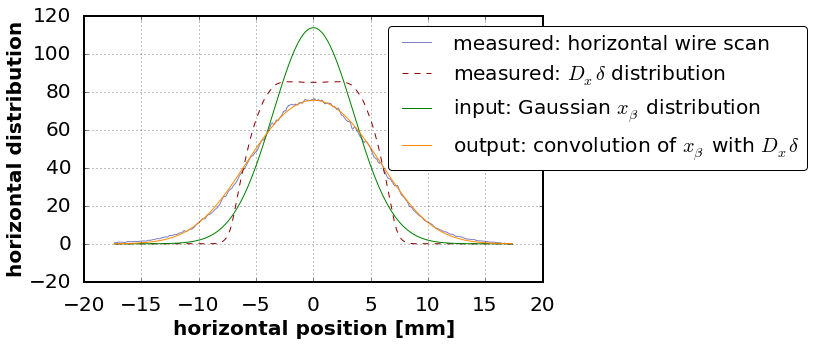

In [383]:
data=data_hollow
data_idx=-1
ctime_idx=0
beta_x=12.62
disp_x=2.3
n_interp_points=1000
savgol_window=7
savgol_order=1

pos = 1e-6 * data['h_position'][ctime_idx][data_idx]
prof = data['h_profile'][ctime_idx][data_idx]
disp_pos = disp_x * data['dp_position'][ctime_idx][data_idx]
disp_prof = data['dp_profile'][ctime_idx][data_idx] / disp_x

inner_window = (max(np.amin(disp_pos), np.amin(pos)),
                min(np.amax(disp_pos), np.amax(pos)))

fit_quantities = fit_gauss(pos, prof)

interp_pos = np.linspace(*inner_window, num=n_interp_points)
interp_prof = np.interp(
    interp_pos, pos - fit_quantities['fit_mu_core'], 
    prof - fit_quantities['baseline'])
interp_fprof = savgol_filter(
    interp_prof, savgol_window, savgol_order)
interp_disp_prof = np.interp(interp_pos, disp_pos, disp_prof)

interp_fprof /= np.trapz(interp_fprof, interp_pos)
interp_disp_prof /= np.trapz(interp_disp_prof, interp_pos)

sig = fit_quantities['fit_sigma_core'] * 0.7
x = interp_pos
xbeta = np.exp(-x**2/(2*sig**2))
xbeta /= np.trapz(xbeta, x)
xdeltap = interp_disp_prof

xmeas = interp_fprof

dx = interp_pos[1] - interp_pos[0]
xconv = np.convolve(xbeta, xdeltap, 'same') * dx

# plt.figure(figsize=(8,5))
# plt.plot(x, xbeta, c='black', label=r'estimated $x_\beta$ distribution ($\sigma=0.7$)')
# plt.plot(x, xdeltap, c='orange', label=r'$\delta$ distribution')
# plt.plot(x, xconv, c='blue', label=r'convolution of black and green')
# plt.plot(x, xmeas, c='lightblue', ls='-', alpha=0.8, lw=3, label='actual horizontal wire scan data')
# plt.xlim(-2e-2, 2e-2)
# plt.legend(bbox_to_anchor=(1.8, 0.8))
# plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right')
# plt.grid(True)

# algorithm: least squares 

fiterror_func = make_fiterror_function(
    x=interp_pos, disp_profile=interp_disp_prof, 
    x_profile=interp_fprof
)

sigma_betatron = scipy.optimize.leastsq(
    fiterror_func, fit_quantities['fit_sigma_core'])[0][0]
print ("The algorithm finds", sigma_betatron/fit_quantities['fit_sigma_core'], "instead of 0.7")

xbeta2 = np.exp(-x**2/(2*sigma_betatron**2))
xbeta2 /= np.trapz(xbeta2, x)
xconv2 = np.convolve(xbeta2, xdeltap, 'same') * dx

plt.figure(figsize=(8,5))
plt.plot(1e3*x, xmeas, c='darkblue', alpha=0.5, 
         label='measured: horizontal wire scan')
plt.plot(1e3*x, xdeltap, c='darkred', ls='--',
         label=r'measured: $D_x \delta$ distribution')
plt.plot(1e3*x, xbeta2, c='green', 
         label=r'input: Gaussian $x_\beta$ distribution')
plt.plot(1e3*x, xconv2, c='darkorange', 
         label=r'output: convolution of $x_\beta$ with $D_x\delta$')
plt.xlim(-20, 20)
lgd = plt.legend(bbox_to_anchor=(1.6, 1))
# plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right')
plt.grid(True)

plt.xlabel('horizontal position [mm]')
plt.ylabel('horizontal distribution')

plt.tight_layout()
plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/convolution.pdf', 
            bbox_extra_artists=(lgd,), bbox_inches='tight')

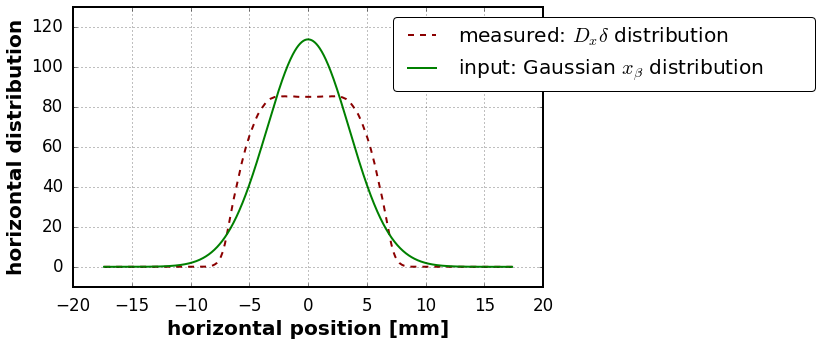

In [225]:
plt.figure(figsize=(8,5))
plt.plot(1e3*x, xdeltap, c='darkred', ls='--', lw=2,
         label=r'measured: $D_x \delta$ distribution' + ' '*13)
plt.plot(1e3*x, xbeta2, c='green', lw=2, #ls=':',
         label=r'input: Gaussian $x_\beta$ distribution')
plt.plot(1e3*x, xmeas, '.-', c='blue', #alpha=0.3, 
         label='measured: horizontal wire scan')
plt.plot(1e3*x, xconv2, c='darkorange', lw=2, #ls=':',
         label=r'output: convolution of $x_\beta$ with $D_x\delta$')
plt.xlim(-20, 20)
plt.ylim(-10, 130)
lgd = plt.legend(bbox_to_anchor=(1.6, 1))
# plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right')
plt.grid(True)

plt.xlabel('horizontal position [mm]')
plt.ylabel('horizontal distribution')

plt.tight_layout()
plt.savefig('/home/oeftiger/cern/documents/latex/16-03-04--MSWG-hollow-bunches/'
            'images/convolution.pdf', 
            bbox_extra_artists=(lgd,), bbox_inches='tight')

In [345]:
print ('a synchrotron period takes',
       1/np.sqrt(7 * abs(1/gamma**2 - 0.027) * e * 25e3 * np.cos(0)
             / (2 * np.pi * beta**2 * gamma*m_p*c**2)),
       'turns')

a synchrotron period takes 724.96664378 turns


In [349]:
print ("20cm are traversed at 15m/s within",
       0.02/15/(100*2*np.pi/beta/c),
       "turns")

20cm are traversed at 15m/s within 582.715485611 turns


Steve's suggestion: 2D plot with guessed sigma vs guessed dispersion in x

In [13]:
def make_conv_function_incl_disp(x, deltap_pos, deltap_profile, x_profile):
    '''Arguments:
        x: 1D array with regularly spaced positions
        deltap_pos: 1D array with (possibly irregular) momentum positions
        deltap_profile: 1D array with deltap momentum values along deltap_pos
        x_profile: 1D array with measured horizontal profile from wire scanner
    '''
    dx = x[1] - x[0]
    def conv_function(sigma, disp_x):
        '''Arguments:
            sigma: standard deviation of assumed Gaussian distribution
            disp_x: assumed dispersion at wire scanner
        '''
        betatron_profile = np.exp(-x**2 / (2*sigma**2))
        betatron_profile /= np.trapz(betatron_profile, x)
        
        irr_disp_pos = disp_x * deltap_pos
        irr_disp_prof = deltap_profile / disp_x
        disp_profile = np.interp(x, irr_disp_pos, irr_disp_prof)
        disp_profile /= np.trapz(disp_profile, x)
        
        x_profile_estimate = np.convolve(betatron_profile, disp_profile, 'same') * dx
        return x_profile_estimate
    return conv_function

In [14]:
from scipy.stats import power_divergence
from operator import attrgetter

irr_deltap_pos = data['dp_position'][ctime_idx][data_idx]
irr_deltap_prof = data['dp_profile'][ctime_idx][data_idx]

conv_func = make_conv_function_incl_disp(
    x=x, deltap_pos=irr_deltap_pos,
    deltap_profile=irr_deltap_prof,
    x_profile=interp_fprof
)

res = power_divergence(conv_func(sigma_betatron, disp_x)[:997], interp_fprof[:997], lambda_='log-likelihood')
print (res)

(176.76881561454448, 1.0)


In [69]:
range_ = 0.5
sigs_s = np.linspace(sigma_betatron * range_, sigma_betatron / range_, 100)
disps_s = np.linspace(disp_x * range_ * 0.1, disp_x / range_, 100)

sigs, disps = np.meshgrid(sigs_s, disps_s)

res = [power_divergence(conv_func(sig, disp)[:997], 
                        interp_fprof[:997], 
                        lambda_='log-likelihood')
       for sig, disp in zip(sigs.ravel(), disps.ravel())]


In [70]:
# res_stats = np.array(map(attrgetter('statistic'), res)).reshape(100, 100)
# res_pval = np.array(map(attrgetter('pvalue'), res)).reshape(100, 100)
from operator import itemgetter
res_stats = np.array(map(itemgetter(0), res)).reshape(100, 100)
res_pval = np.array(map(itemgetter(1), res)).reshape(100, 100)

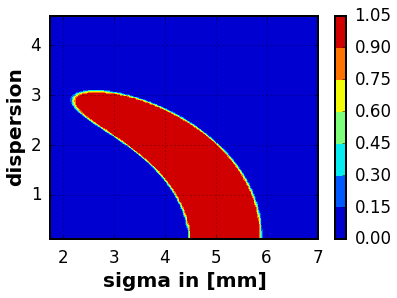

In [71]:
plt.contourf(1e3*sigs, disps, res_pval)
plt.colorbar()
plt.grid(True)
plt.xlabel('sigma in [mm]')
plt.ylabel('dispersion')

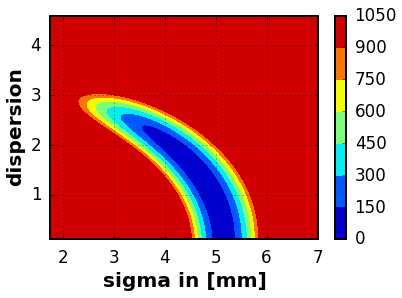

In [128]:
plt.contourf(1e3*sigs, disps, np.clip(res_stats, 0, 1000))
plt.colorbar()
plt.grid(True)
plt.xlabel('sigma in [mm]')
plt.ylabel('dispersion');

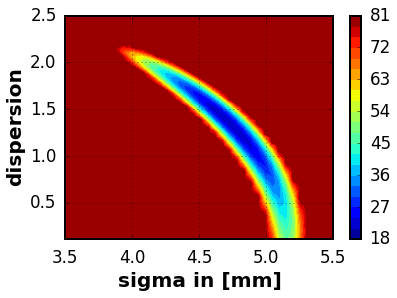

In [130]:
plt.contourf(1e3*sigs, disps, np.clip(res_stats, 0, 80), 20)
plt.colorbar()
plt.xlim(3.5, 5.5)
plt.ylim(np.min(disps), 2.5)
plt.grid(True)
plt.xlabel('sigma in [mm]')
plt.ylabel('dispersion');

In [136]:
idx = np.argmin(res_stats.ravel())
sig_chi2 = sigs.ravel()[idx]
disp_chi2 = disps.ravel()[idx]
print ("Estimated from the 2D scan: \ndisp_x = {1:.3f} m\nemit_x = {0:.3f} umrad\n".format(
        sig_chi2**2/beta_x*1e6*beta*gamma, disp_chi2))
print ("In contrast, for a fixed dispersion of\ndisp_x = {1:.3f} m"
       "\nthe least_squares algorithm finds\nemit_x = {0:.3f} umrad".format(
       sigma_betatron**2/beta_x*1e6*beta*gamma, disp_x))

Estimated from the 2D scan: 
disp_x = 1.429 m
emit_x = 3.948 umrad

In contrast, for a fixed dispersion of
disp_x = 2.300 m
the least_squares algorithm finds
emit_x = 2.220 umrad


### testing of horizontal wire scan dispersion removal:

0.00350374719455


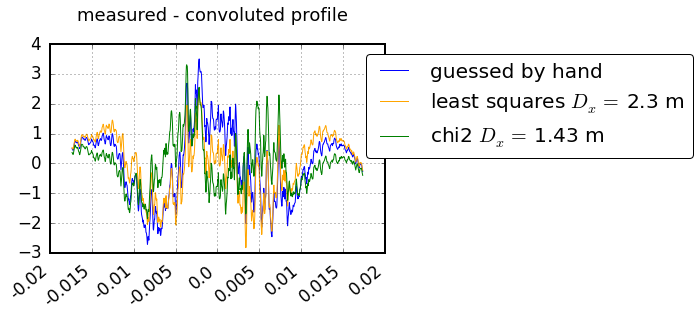

In [122]:
fiterror_func = make_fiterror_function(
    x=interp_pos, disp_profile=interp_disp_prof, 
    x_profile=interp_fprof
)

sigma = scipy.optimize.leastsq(fiterror_func, fit_quantities['fit_sigma_core'])[0][0]

plt.plot(interp_pos, xmeas - xconv, c='blue', label='guessed by hand')
plt.plot(interp_pos, fiterror_func(sigma), 'orange', label='least squares $D_x=$ 2.3 m')
plt.plot(interp_pos, xmeas - conv_func(sig_chi2, disp_chi2), label='chi2 $D_x=$ {0:.2f} m'.format(disp_chi2))
plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.95,1))
plt.suptitle('measured - convoluted profile', fontsize=18)
plt.subplots_adjust(top=0.85)

print (sigma)

This above plot shows the deviation of the betatron part from a pure Gaussian distribution: actually it's thinner on the flanks and higher on the top as compared to a Gaussian.

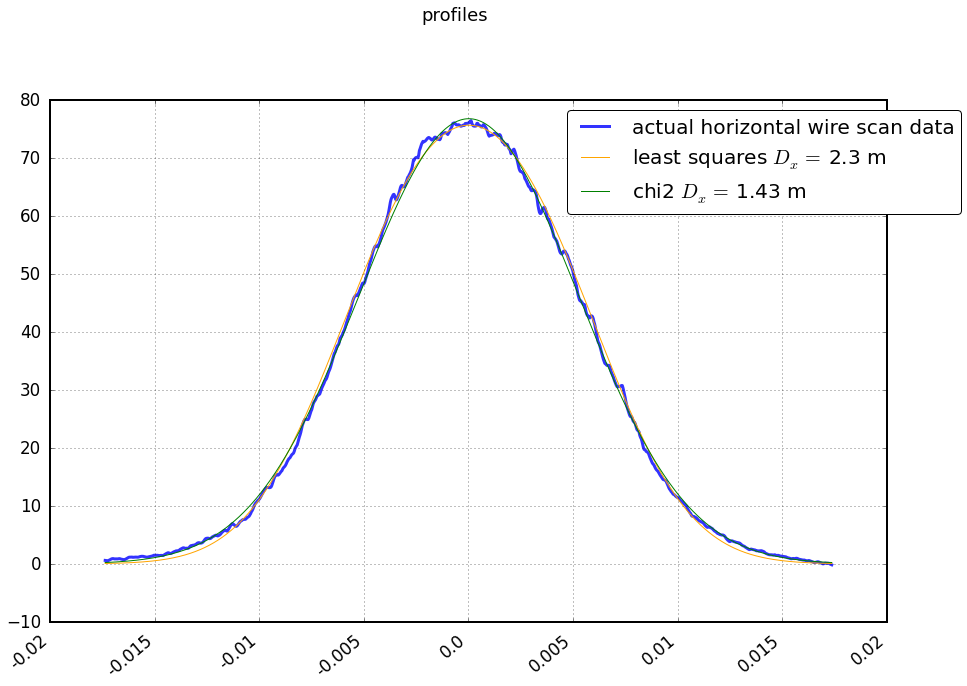

In [126]:
plt.figure(figsize=(15,10))
plt.plot(interp_pos, xmeas, c='lightblue', ls='-', alpha=0.8, lw=3, label='actual horizontal wire scan data')
plt.plot(interp_pos, conv_func(sigma, disp_x), 'orange', label='least squares $D_x=$ 2.3 m')
plt.plot(interp_pos, conv_func(sig_chi2, disp_chi2), label='chi2 $D_x=$ {0:.2f} m'.format(disp_chi2))
plt.gca().set_xticklabels(plt.gca().get_xticks(), rotation=40, ha='right')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.1,1))
plt.suptitle('profiles', fontsize=18)
plt.subplots_adjust(top=0.85)

### loop to evaluate all transverse emittances, beam sizes and space charge tune shifts

In [202]:
Ekin = 1.4e9 * e
gamma = 1 + Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
rp = e**2 / (4 * np.pi * epsilon_0 * m_p * c**2)
C = 100 * 2 * np.pi

for data in (data_hollow, data_gauss):
    n_meas = len(data['bct'])

    data['emit_x'] = (np.empty(n_meas, dtype=float), np.empty(n_meas, dtype=float))
    data['emit_y'] = (np.empty(n_meas, dtype=float), np.empty(n_meas, dtype=float))
    data['std_x'] = (np.empty(n_meas, dtype=float), np.empty(n_meas, dtype=float))
    data['std_y'] = (np.empty(n_meas, dtype=float), np.empty(n_meas, dtype=float))
    data['core_sig_x'] = (np.empty(n_meas, dtype=float), np.empty(n_meas, dtype=float))
    data['core_sig_y'] = (np.empty(n_meas, dtype=float), np.empty(n_meas, dtype=float))

    for idx in xrange(n_meas):
        #C185
        emit_geo, h_fit_quantities = get_h_emit_geo(data, idx, 0)
        data['emit_x'][0][idx] = emit_geo * beta * gamma
        emit_geo, v_fit_quantities = get_v_emit_geo(data, idx, 0)
        data['emit_y'][0][idx] = emit_geo * beta * gamma
        data['std_x'][0][idx] = h_fit_quantities['std']
        data['std_y'][0][idx] = v_fit_quantities['std']
        data['core_sig_x'][0][idx] = h_fit_quantities['fit_sigma_core']
        data['core_sig_y'][0][idx] = v_fit_quantities['fit_sigma_core']
        
        #C1350
        emit_geo, h_fit_quantities = get_h_emit_geo(data, idx, 1)
        data['emit_x'][1][idx] = emit_geo * beta * gamma
        emit_geo, v_fit_quantities = get_v_emit_geo(data, idx, 1)
        data['emit_y'][1][idx] = emit_geo * beta * gamma
        data['std_x'][1][idx] = h_fit_quantities['std']
        data['std_y'][1][idx] = v_fit_quantities['std']
        data['core_sig_x'][1][idx] = h_fit_quantities['fit_sigma_core']
        data['core_sig_y'][1][idx] = v_fit_quantities['fit_sigma_core']

### deviation of advanced emit_x method vs. usual Gaussian formula

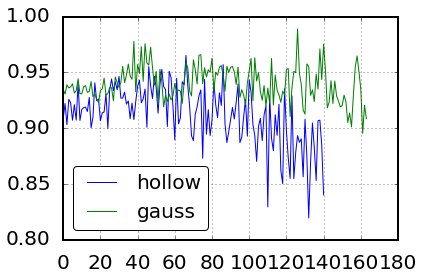

In [385]:
# plt.plot(data_hollow['emit_x'][0] / 
#          ((data_hollow['std_x'][0]**2 - disp_x**2 * data_hollow['deltap'][0]**2) / beta_x * beta * gamma))
# plt.plot(data_gauss['emit_x'][0] / 
#          ((data_gauss['std_x'][0]**2 - disp_x**2 * data_gauss['deltap'][0]**2) / beta_x * beta * gamma))

plt.plot(data_hollow['emit_x'][0] / 
         ((data_hollow['core_sig_x'][0]**2 - 
           disp_x**2 * data_hollow['deltap'][0]**2) / beta_x * beta * gamma),
        label='hollow')
plt.plot(data_gauss['emit_x'][0] / 
         ((data_gauss['core_sig_x'][0]**2 - 
           disp_x**2 * data_gauss['deltap'][0]**2) / beta_x * beta * gamma),
        label='gauss')
plt.grid(True);
plt.legend(loc=3);

Hollow distributions deviate even further than quasi-Gaussian ones

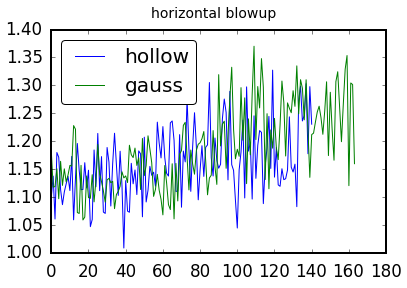

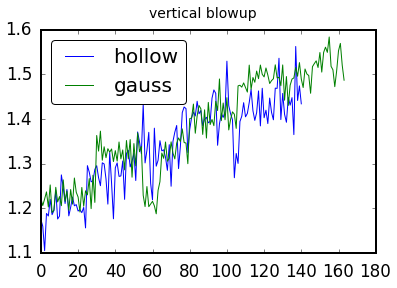

In [22]:
plt.plot(data_hollow['emit_x'][1]/data_hollow['emit_x'][0], label='hollow')
plt.plot(data_gauss['emit_x'][1]/data_gauss['emit_x'][0], label='gauss')
plt.suptitle('horizontal blowup')
plt.legend(loc=0)

plt.figure()
plt.plot(data_hollow['emit_y'][1]/data_hollow['emit_y'][0], label='hollow')
plt.plot(data_gauss['emit_y'][1]/data_gauss['emit_y'][0], label='gauss')
plt.suptitle('vertical blowup')
plt.legend(loc=0);

## summary plot bunch length scan

In [203]:
# I_to_lambda_max = 9.36226e9
# conversion_factor taken from tomography Mathematica script (tomo_en_masse)
# Max[Tomogram`Private`profile] / 
#     Max[Cases[Tomogram`Private`p2[],Line[{x__}]->x,Infinity][[201;;400,2]]]
# comes from 1/(dtbin beta c) * 1/(beta c e) (first part is dz conversion 
# and second is current to intensity per dz unit conversion)

I_to_lambda_max = 1. / (beta * c * e)

hollow coeff: 208.379635696
gauss  coeff: 231.96392748
ratio hollow / gauss: 0.898327761389


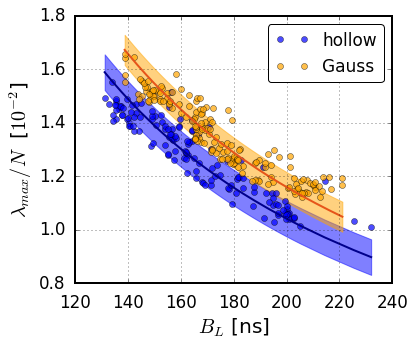

In [81]:
# geometry of hollow vs. quasi-Gaussian bunches,
# quality assessment in terms of peak line density depression
blh = data_hollow['bunchlength'][0]
blg = data_gauss['bunchlength'][0]
# geoh = data_hollow['peakcurrent'][0] / (beta * c * e) / data_hollow['intensity'][0]
# geog = data_gauss['peakcurrent'][0] / (beta * c * e) / data_gauss['intensity'][0]
geoh = data_hollow['peakcurrent'][0] * I_to_lambda_max / data_hollow['eperimage'][0]
geog = data_gauss['peakcurrent'][0] * I_to_lambda_max / data_gauss['eperimage'][0]

geofac = 100

plt.figure(figsize=(6,5))
# plt.suptitle('depression of peak line density', fontsize=18)
# plt.subplots_adjust(top=0.85)
# plt.xlabel('bunch length [ns]')
plt.xlabel('$B_L$ [ns]', fontweight=None)
plt.ylabel('$\lambda_{max} / N$  [$10^{-2}$]', fontweight=None)
plt.grid(True)

plt.plot(blh, geofac * geoh, label='hollow', c='blue', ls='None', marker='o', alpha=0.7)
plt.plot(blg, geofac * geog, label='Gauss', c='orange', ls='None', marker='o', alpha=0.7)

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    blh, geofac * geoh, (1./blh,), conf_level_sigma=1)
plt.plot(xdata_h, yfit_h, c='darkblue', lw=2)
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.5)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    blg, geofac * geog, (1./blg,), conf_level_sigma=1)
plt.plot(xdata_g, yfit_g, c='#e6541a', lw=2)
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.5)

plt.legend(fontsize=17)

plt.tight_layout()

# plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
#             'images/ch5_hollow_bunches/lambdamax_depression.pdf')

plt.savefig('/home/oeftiger/cern/documents/latex/'
            '16-04-06-IPAC-hollow-bunches/images/'
            'lambdamax_depression.pdf')

print ('hollow coeff:', results_h.params[0])
print ('gauss  coeff:', results_g.params[0])
print ('ratio hollow / gauss:', results_h.params[0] / results_g.params[0])

hollow coeff: 513.233583262
gauss  coeff: 567.122948512
ratio hollow / gauss: 0.904977632467


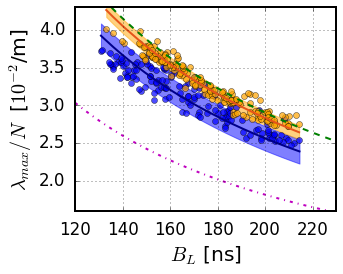

In [210]:
# geometry of hollow vs. quasi-Gaussian bunches,
# quality assessment in terms of peak line density depression
blh = data_hollow['bunchlength'][1]
blg = data_gauss['bunchlength'][1]
geoh = data_hollow['peakcurrent'][1] * I_to_lambda_max / data_hollow['eperimage'][1]
geog = data_gauss['peakcurrent'][1] * I_to_lambda_max / data_gauss['eperimage'][1]

geofac = 100
xlim = (120, 230)
ylim = (1.6, 4.3)

legendfig = plt.figure(figsize=(2.2,4))

fig = plt.figure(figsize=(5,4))
# plt.suptitle('depression of peak line density', fontsize=18)
# plt.subplots_adjust(top=0.85)
# plt.xlabel('bunch length [ns]')
plt.xlabel('$B_L$ [ns]', fontweight=None)
plt.ylabel('$\lambda_{max} / N$  [$10^{-2}$/m]', fontweight=None)
plt.grid(True)

hollowscatter, = plt.plot(blh, geofac * geoh, label='hollow', 
                          c='blue', ls='None', marker='o', alpha=0.7)
gaussscatter, = plt.plot(blg, geofac * geog, label='Gauss', 
                         c='orange', ls='None', marker='o', alpha=0.7)

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    blh, geofac * geoh, (1./blh,), conf_level_sigma=1)
hollowfitline, = plt.plot(xdata_h, yfit_h, c='darkblue', lw=2)
hollowfitcb = plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.5)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    blg, geofac * geog, (1./blg,), conf_level_sigma=1)
gaussfitline, = plt.plot(xdata_g, yfit_g, c='#e6541a', lw=2)
gaussfitcb = plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.5)

plt.xlim(xlim)
plt.ylim(ylim)

bl_sampling = np.linspace(*xlim, num=100)
# lambda_max for perfect Gauss of corresponding 4 sigma_z bunch length
gaussline, = plt.plot(
    bl_sampling, 4/(np.sqrt(2*np.pi)*bl_sampling) * 1e9/(beta*c) * geofac, 
    'g--', lw=2
)
# optimal lambda_max for rectangular distribution over 4 sigma_z
rectline, = plt.plot(
    bl_sampling, 1e9/bl_sampling / (beta * c) * geofac, 
    'm-.', lw=2)

plt.tight_layout()

# plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
#             'images/ch5_hollow_bunches/lambdamax_depression.pdf')

plt.xlim(xlim)
plt.ylim(ylim)

import matplotlib.patches as mpatches
import matplotlib.lines as mlines

class FitHandler(object):
    def __init__(self, patch_color, line_color):
        self.patch_color = patch_color
        self.line_color = line_color
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle(
            [x0, y0], width, height, color=self.patch_color, alpha=0.5,
            transform=handlebox.get_transform())
        line = mlines.Line2D(
            [x0, x0 + width], [y0 + height/2., y0 + height/2.], 
            color=self.line_color, lw=2)
        handlebox.add_artist(patch)
        handlebox.add_artist(line)
        return patch

legendfig.legend(
    [gaussscatter, hollowscatter,
     gaussfitline, hollowfitline,
     gaussline, rectline, ],
    ['parabolic\nbunches', 'hollow\nbunches',
     'parabolic fit\n' + r'with $1\sigma$ c.b.', 
     'hollow fit\n' + r'with $1\sigma$ c.b.',
     'ideal\nGaussian\nprofile', 'ideal\nrectangular\nprofile', ],
    handler_map={gaussfitline: FitHandler('orange', '#e6541a'),
                 hollowfitline: FitHandler('blue', 'darkblue')},
    numpoints=3,
    loc='center', fontsize=15)

# fig.savefig('/home/oeftiger/cern/documents/latex/'
#             '16-04-06-IPAC-hollow-bunches/images/'
#             'lambdamax_depression.pdf')

# legendfig.savefig('/home/oeftiger/cern/documents/latex/'
#                   '16-04-06-IPAC-hollow-bunches/images/'
#                   'legend.pdf')

print ('hollow coeff:', results_h.params[0])
print ('gauss  coeff:', results_g.params[0])
print ('ratio hollow / gauss:', results_h.params[0] / results_g.params[0])

In [195]:
gaussscatter

In [414]:
h_blowup_hollow = data_hollow['emit_x'][1] / data_hollow['emit_x'][0]
h_blowup_gauss = data_gauss['emit_x'][1] / data_gauss['emit_x'][0]
v_blowup_hollow = data_hollow['emit_y'][1] / data_hollow['emit_y'][0]
v_blowup_gauss = data_gauss['emit_y'][1] / data_gauss['emit_y'][0]

(0.90000000000000002, 1.7000000000000002)

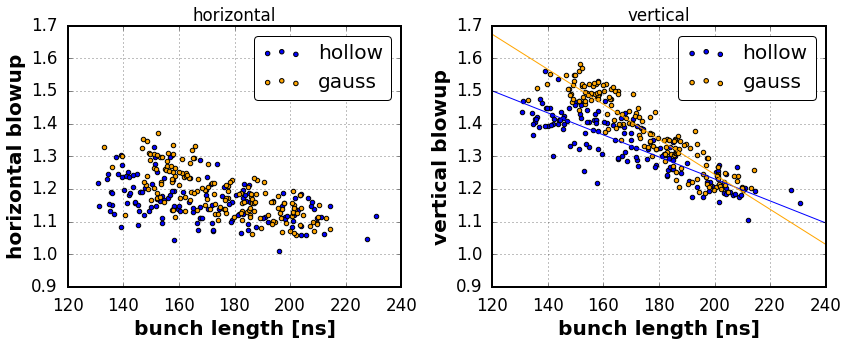

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(data_hollow['bunchlength'][1], 
            h_blowup_hollow,
            c='blue', label='hollow')
plt.scatter(data_gauss['bunchlength'][1], 
            h_blowup_gauss,
            c='orange', label='gauss')
plt.legend()
plt.grid(True)
plt.xlabel('bunch length [ns]')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(data_hollow['bunchlength'][1], 
            v_blowup_hollow,
            c='blue', label='hollow')
plt.scatter(data_gauss['bunchlength'][1], 
            v_blowup_gauss,
            c='orange', label='gauss')
plt.legend()
plt.grid(True)
plt.xlabel('bunch length [ns]')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

vbu_bf_hollow_fn = np.poly1d(np.polyfit(data_hollow['bunchlength'][1], v_blowup_hollow, 1))
vbu_bf_gauss_fn = np.poly1d(np.polyfit(data_gauss['bunchlength'][1], v_blowup_gauss, 1))

plt.plot(xlim, vbu_bf_hollow_fn(xlim), c='blue')
plt.plot(xlim, vbu_bf_gauss_fn(xlim), c='orange')

plt.xlim(xlim)
plt.ylim(ylim);

# plt.savefig('/home/oeftiger/bunchlength.pdf')

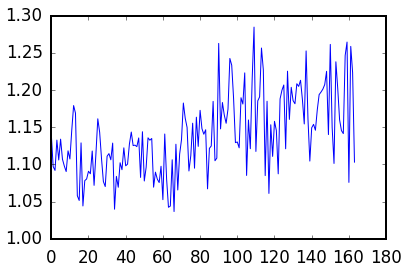

In [72]:
plt.plot(h_blowup_gauss / h_rmsblowup_gauss)

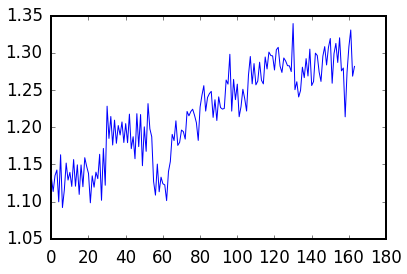

In [71]:
plt.plot(v_blowup_gauss / v_rmsblowup_gauss)

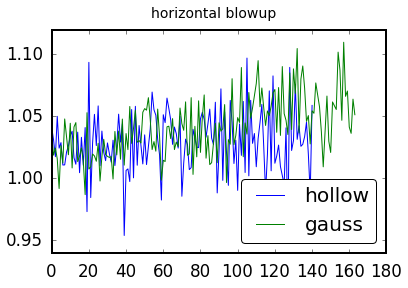

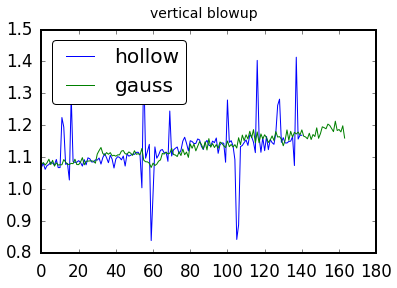

In [8]:
plt.plot(data_hollow['std_x'][1]/data_hollow['std_x'][0], label='hollow')
plt.plot(data_gauss['std_x'][1]/data_gauss['std_x'][0], label='gauss')
plt.suptitle('horizontal blowup')
plt.legend(loc=0)

plt.figure()
plt.plot(data_hollow['std_y'][1]/data_hollow['std_y'][0], label='hollow')
plt.plot(data_gauss['std_y'][1]/data_gauss['std_y'][0], label='gauss')
plt.suptitle('vertical blowup')
plt.legend(loc=0);

In [233]:
h_rmsblowup_hollow = data_hollow['std_x'][1] / data_hollow['std_x'][0]
h_rmsblowup_gauss = data_gauss['std_x'][1] / data_gauss['std_x'][0]

v_rmsblowup_hollow = data_hollow['std_y'][1] / data_hollow['std_y'][0]
v_rmsblowup_gauss = data_gauss['std_y'][1] / data_gauss['std_y'][0]

Use the standard deviation RMS emittance and not the Gaussian fit? It seems like the Gaussian fit deviates which fits the explanation by Baartman saying the central part blows up (see his simulation for blowup until certain resonant transverse amplitude).

array([ 11,  12,  15,  16,  20,  37,  52,  53,  57,  58,  67,  97,  98,
       103, 104, 114, 125, 126, 134, 135])

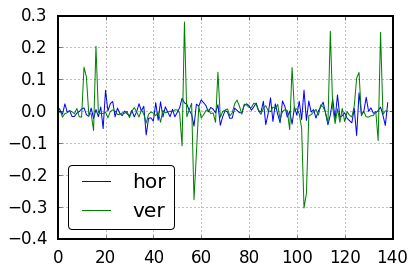

In [234]:
h_fit_fn = np.poly1d(np.polyfit(xrange(len(files_hollow)), h_rmsblowup_hollow, 1))
h_off_fit = (h_rmsblowup_hollow - h_fit_fn(xrange(len(files_hollow))))
v_fit_fn = np.poly1d(np.polyfit(xrange(len(files_hollow)), v_rmsblowup_hollow, 1))
v_off_fit = (v_rmsblowup_hollow - v_fit_fn(xrange(len(files_hollow))))
plt.plot(h_off_fit, label='hor')
plt.plot(v_off_fit, label='ver')
plt.legend(loc=3)
plt.grid(True)

rms_hollow_mask = np.where((np.abs(h_off_fit) <= 0.06) & 
                           (np.abs(v_off_fit) <= 0.055))[0]

np.where((np.abs(h_off_fit) > 0.06) | (np.abs(v_off_fit) > 0.055))[0]

array([], dtype=int64)

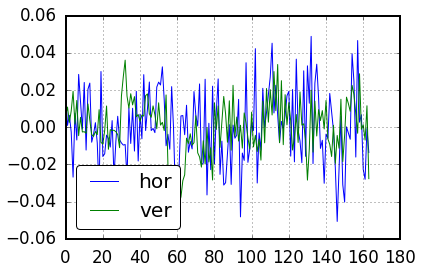

In [215]:
h_fit_fn = np.poly1d(np.polyfit(xrange(len(files_gauss)), h_rmsblowup_gauss, 1))
h_off_fit = (h_rmsblowup_gauss - h_fit_fn(xrange(len(files_gauss))))
v_fit_fn = np.poly1d(np.polyfit(xrange(len(files_gauss)), v_rmsblowup_gauss, 1))
v_off_fit = (v_rmsblowup_gauss - v_fit_fn(xrange(len(files_gauss))))
plt.plot(h_off_fit, label='hor')
plt.plot(v_off_fit, label='ver')
plt.legend(loc=3)
plt.grid(True)

rms_gauss_mask = np.where((np.abs(h_off_fit) <= 0.055) & 
                           (np.abs(v_off_fit) <= 0.055))[0]

np.where((np.abs(h_off_fit) > 0.055) | (np.abs(v_off_fit) > 0.055))[0]

remove all of these outliers with weird baselines / distributions, checking:

In [208]:
plane = 'v'
files = files_hollow
data = data_hollow

from IPython import display
import time

for idx in xrange(len(files)):
    #[ 59,  60, 105, 106]:#[ 11,  16,  55,  69, 100, 116, 127, 128, 137]:#
    pos185 = data[plane + '_position'][0][idx]
    prof185 = data[plane + '_profile'][0][idx]
    pos1350 = data[plane + '_position'][1][idx]
    prof1350 = data[plane + '_profile'][1][idx]

    fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    plt.sca(ax[0])
    plt.cla()
    plt.title('C185')
    fit_quantities = fit_gauss(1e-6 * pos185, prof185)
    plt.plot(1e-6 * pos185, gauss(
        1e-6 * pos185, 
        fit_quantities['fit_ampl_core'], 
        fit_quantities['fit_mu_core'], 
        fit_quantities['fit_sigma_core']),
        c='blue', alpha=0.5, lw=2
    )
    plt.plot(1e-6 * pos185, prof185 - fit_quantities['baseline'], c='red')

    plt.sca(ax[1])
    plt.cla()
    plt.title('C1350')
    fit_quantities = fit_gauss(1e-6 * pos1350, prof1350)
    plt.plot(1e-6 * pos1350, gauss(
        1e-6 * pos1350, 
        fit_quantities['fit_ampl_core'], 
        fit_quantities['fit_mu_core'], 
        fit_quantities['fit_sigma_core']),
        c='blue', alpha=0.5, lw=2
    )
    plt.plot(1e-6 * pos1350, prof1350 - fit_quantities['baseline'], c='red')
    
    plt.suptitle('{idx}.: {fname}'.format(idx=idx, fname=files[idx]), fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.xlim((-2e-2, 2e-2))
    plt.ylim((-0.1, 0.6))
    display.clear_output(wait=True)
    display.display(plt.gcf())
#     time.sleep(1.0)
#     raw_input('...')

(0.90000000000000002, 1.25)

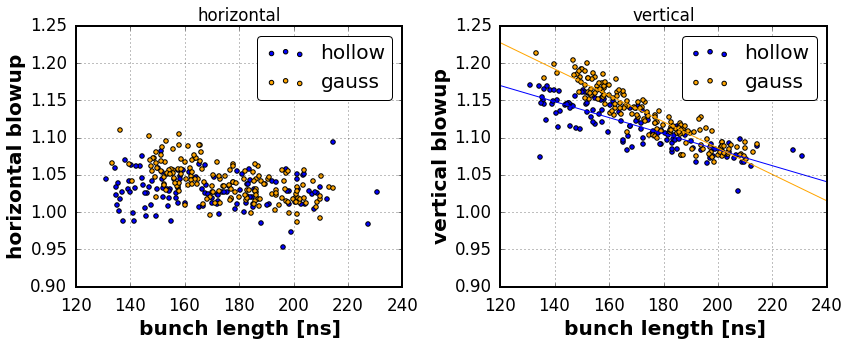

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(data_hollow['bunchlength'][1][rms_hollow_mask], 
            h_rmsblowup_hollow[rms_hollow_mask],
            c='blue', label='hollow')
plt.scatter(data_gauss['bunchlength'][1], 
            h_rmsblowup_gauss,
            c='orange', label='gauss')
plt.legend()
plt.grid(True)
plt.xlabel('bunch length [ns]')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(data_hollow['bunchlength'][1][rms_hollow_mask], 
            v_rmsblowup_hollow[rms_hollow_mask],
            c='blue', label='hollow')
plt.scatter(data_gauss['bunchlength'][1], 
            v_rmsblowup_gauss,
            c='orange', label='gauss')
plt.legend()
plt.grid(True)
plt.xlabel('bunch length [ns]')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

vrmsbu_bf_hollow_fn = np.poly1d(np.polyfit(data_hollow['bunchlength'][1][rms_hollow_mask], 
                                           v_rmsblowup_hollow[rms_hollow_mask], 1))
vrmsbu_bf_gauss_fn = np.poly1d(np.polyfit(data_gauss['bunchlength'][1], 
                                          v_rmsblowup_gauss, 1))

plt.plot(xlim, vrmsbu_bf_hollow_fn(xlim), c='blue')
plt.plot(xlim, vrmsbu_bf_gauss_fn(xlim), c='orange')

plt.xlim(xlim)
plt.ylim(ylim);

# plt.savefig('/home/oeftiger/bunchlength.pdf')

(0.90000000000000002, 1.7000000000000002)

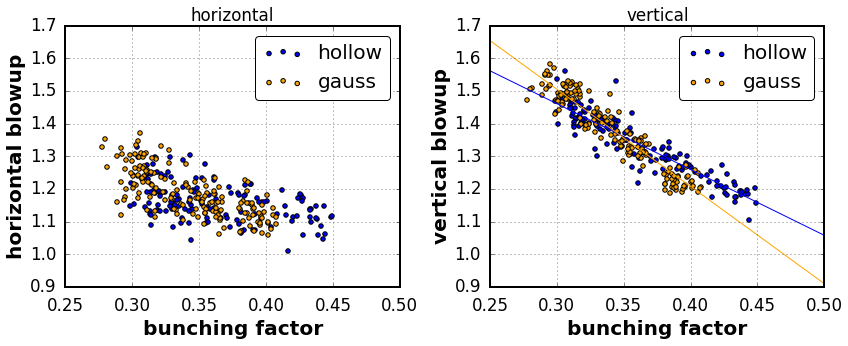

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(data_hollow['bunchingfactor'][1], 
            h_blowup_hollow,
            c='blue', label='hollow')
plt.scatter(data_gauss['bunchingfactor'][1], 
            h_blowup_gauss,
            c='orange', label='gauss')
plt.legend()
plt.grid(True)
plt.xlabel('bunching factor')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(data_hollow['bunchingfactor'][1], 
            v_blowup_hollow,
            c='blue', label='hollow')
plt.scatter(data_gauss['bunchingfactor'][1], 
            v_blowup_gauss,
            c='orange', label='gauss')
plt.legend()
plt.grid(True)
plt.xlabel('bunching factor')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)

plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

vbu_bf_hollow_fn = np.poly1d(np.polyfit(data_hollow['bunchingfactor'][1], v_blowup_hollow, 1))
vbu_bf_gauss_fn = np.poly1d(np.polyfit(data_gauss['bunchingfactor'][1], v_blowup_gauss, 1))

plt.plot(xlim, vbu_bf_hollow_fn(xlim), c='blue')
plt.plot(xlim, vbu_bf_gauss_fn(xlim), c='orange')

plt.xlim(xlim)
plt.ylim(ylim);

# plt.savefig('/home/oeftiger/bunchingfactor.pdf')

The comparison via bunch length lacks the influence of the different intensities of both prepared bunches.

We need to include the intensity!

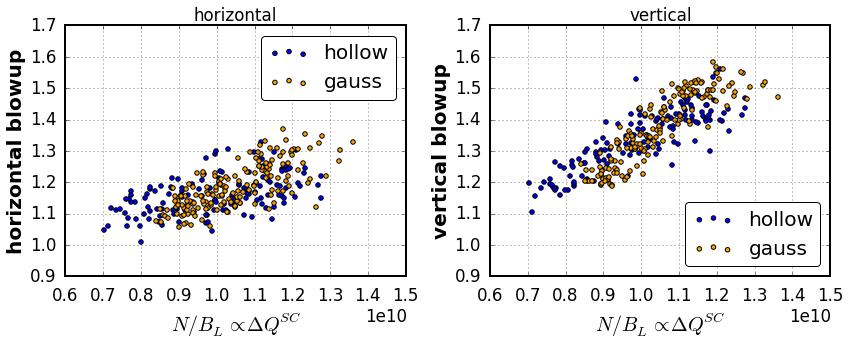

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(data_hollow['intensity'][1] / data_hollow['bunchlength'][1], 
            h_blowup_hollow,
            c='blue', label='hollow')
plt.scatter(data_gauss['intensity'][1] / data_gauss['bunchlength'][1], 
            h_blowup_gauss,
            c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.xlabel(r'$N / B_L \propto \Delta Q^{SC}$')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(data_hollow['intensity'][1] / data_hollow['bunchlength'][1], 
            v_blowup_hollow,
            c='blue', label='hollow')
plt.scatter(data_gauss['intensity'][1] / data_gauss['bunchlength'][1], 
            v_blowup_gauss,
            c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel(r'$N / B_L \propto \Delta Q^{SC}$')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

In [13]:
print ("emit_y in: ", data_gauss['emit_y'][0][idx])
print ("emit_y out:", data_gauss['emit_y'][1][idx])

emit_y in:  2.40318630056e-06
emit_y out: 3.57260676992e-06


Since both beams also come with different initial emittances, the beam dynamics are not sufficiently comparable by only the intensity and the bunch length.

We need to include the initial emittances:

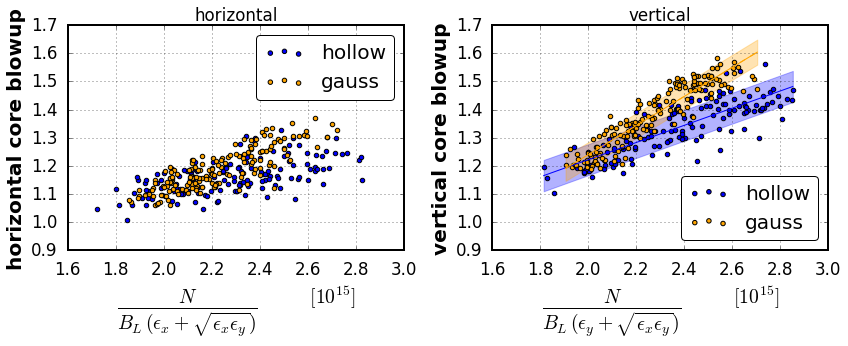

In [122]:
dQx_hollow = (
    data_hollow['intensity'][0] / data_hollow['bunchlength'][1] /
    (data_hollow['emit_x'][0] + 
     np.sqrt(data_hollow['emit_x'][0] * data_hollow['emit_y'][0]))
) * 1e-15
dQx_gauss = (
    data_gauss['intensity'][0] / data_gauss['bunchlength'][1] /
    (data_gauss['emit_x'][0] + 
     np.sqrt(data_gauss['emit_x'][0] * data_gauss['emit_y'][0]))
) * 1e-15

dQy_hollow = (
    data_hollow['intensity'][0] / data_hollow['bunchlength'][1] /
    (data_hollow['emit_y'][0] + 
     np.sqrt(data_hollow['emit_x'][0] * data_hollow['emit_y'][0]))
) * 1e-15
dQy_gauss = (
    data_gauss['intensity'][0] / data_gauss['bunchlength'][1] /
    (data_gauss['emit_y'][0] + 
     np.sqrt(data_gauss['emit_x'][0] * data_gauss['emit_y'][0]))
) * 1e-15

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(dQx_hollow, h_blowup_hollow, c='blue', label='hollow')
plt.scatter(dQx_gauss, h_blowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.xlabel(r'$\frac{N}{B_L \, (\epsilon_x + \sqrt{\epsilon_x \epsilon_y})}'
           '\qquad {}^{[10^{15}]}$',
          fontsize=28)# +
#            r'\propto \Delta Q_x^{SC}$' + 
#            ' '*8)
plt.ylabel('horizontal core blowup')
plt.title('horizontal')

plt.sca(ax[1])

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    dQy_hollow, v_blowup_hollow, (dQy_hollow,), conf_level_sigma=1, add_constant=True)
plt.plot(xdata_h, yfit_h, c='blue')
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.3)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    dQy_gauss, v_blowup_gauss, (dQy_gauss,), conf_level_sigma=1, add_constant=True)
plt.plot(xdata_g, yfit_g, c='orange')
plt.plot(xdata_g, yfit_g, c='orange', ls='--')
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.3)

plt.scatter(dQy_hollow, v_blowup_hollow, c='blue', label='hollow')
plt.scatter(dQy_gauss, v_blowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel(r'$\frac{N}{B_L \, (\epsilon_y + \sqrt{\epsilon_x \epsilon_y})}'
           '\qquad {}^{[10^{15}]}$',
          fontsize=28)# +
#            r'\propto \Delta Q_y^{SC}$' + 
#            ' '*8)
plt.ylabel('vertical core blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

# vbu_bf_hollow_fn = np.poly1d(np.polyfit(dQy_hollow, v_blowup_hollow, 1))
# vbu_bf_gauss_fn = np.poly1d(np.polyfit(dQy_gauss, v_blowup_gauss, 1))

# plt.plot(xlim, vbu_bf_hollow_fn(xlim), c='blue')
# plt.plot(xlim, vbu_bf_gauss_fn(xlim), c='orange')

# plt.xlim(xlim)
# plt.ylim(ylim);

plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/coreblowup_vs_nblemit.pdf');

In [112]:
print ("matched emittance C185 = ", np.mean(data_gauss['matchedemittance'][0]), 
       "+-", np.std(data_gauss['matchedemittance'][0]))

print ("matched emittance C185 = ", np.mean(data_hollow['matchedemittance'][0]), 
       "+-", np.std(data_hollow['matchedemittance'][0]))

print ("matched emittance C1350 =", np.mean(data_gauss['matchedemittance'][1]), 
       "+-", np.std(data_gauss['matchedemittance'][1]))

print ("matched emittance C1350 =", np.mean(data_hollow['matchedemittance'][1]), 
       "+-", np.std(data_hollow['matchedemittance'][1]))

matched emittance C185 =  1.47146198165 +- 0.10988782937
matched emittance C185 =  1.42932849314 +- 0.154041990625
matched emittance C1350 = 1.4724877314 +- 0.0891897606924
matched emittance C1350 = 1.46061859437 +- 0.156281506584


Regarding Gianni's suggestion: we cannot Poisson-solve the wire scan to get the space charge tune shift as the profile integrates over the longitudinal plane. We need the longitudinal information for the x-axis... The definition of the x-axis / direct space charge tune shift via the Gaussian expression is better suited for comparing the two. (In either case, the horizontal plane for the hollow distribution does not depart too much from a Gaussian, in the case of the tune shift formula the difference is negligible.)

This justifies using $\Delta Q^{SC}$ via the Gaussian expression $\Delta Q_x^{SC} \propto \int \frac{\beta_x(s) ds}{\sigma_x(s) (\sigma_x(s) + \sigma_y(s))} \sim 1/(\epsilon_x + \sqrt{\epsilon_x \epsilon_y})$ in order to compare the two beams.

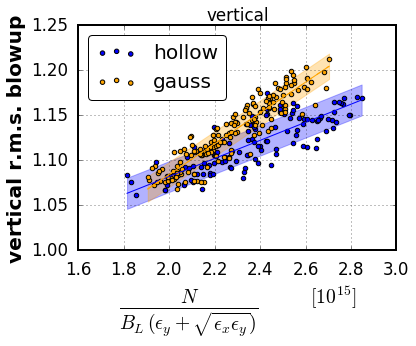

In [121]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), sharex=True, sharey=True)

plt.sca(ax)
plt.xlabel(r'$\frac{N}{B_L \, (\epsilon_y + \sqrt{\epsilon_x \epsilon_y})}'
           '\qquad {}^{[10^{15}]}$',
          fontsize=28)# +
#            r'\propto \Delta Q_y^{SC}$' + ' '*8)
plt.ylabel('vertical r.m.s. blowup')
plt.title('vertical')

# --- confidence intervals:

# from scipy.stats.distributions import t
# alpha = 1 - 0.95 # corresponds to 95% confidence level
# # def fitfunc(x, c2): return 1 + c2 * x**2
# # def paramjacobian(x, c2cov): return c2cov * x**4
# def fitfunc(x, c0, c1): return c0 + c1 * x
# def paramjacobian(x, c00cov, c01cov, c10cov, c11cov): 
#     return c00cov + (c01cov + c10cov) * x + c11cov * x**2

# # hollow ci
# xdata = dQy_hollow[rms_hollow_mask]
# ydata = v_rmsblowup_hollow[rms_hollow_mask]
# col = 'blue'

# # https://www.astro.rug.nl/software/kapteyn/
# # kmpfittutorial.html#confidence-and-prediction-intervals

# cs, cov = curve_fit(fitfunc, xdata, ydata)
# cs_hollow = cs

# dof = max(0, len(xdata) - len(cs))
# tval = t.ppf(1.0-alpha/2., dof)
# stderr = 1 / np.sqrt(len(xdata))
# reduced_chisq = dof**-1 * np.sum((ydata**2 - fitfunc(xdata, *cs))**2) / stderr**2
# reduced_chisq_hollow = reduced_chisq

# xminmax = np.linspace(np.min(xdata), np.max(xdata), num=100)
# yfitted = fitfunc(xminmax, *cs)
# yupperci = yfitted + tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))
# ylowerci = yfitted - tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))

# plt.plot(xminmax, yfitted, c=col)
# plt.plot(xminmax, ylowerci, c=col, alpha=0.5, ls='--')
# plt.plot(xminmax, yupperci, c=col, alpha=0.5, ls='--')

# plt.fill_between(xminmax, ylowerci, yupperci, color=col, alpha=0.3)

# # gauss ci
# xdata = dQy_gauss
# ydata = v_rmsblowup_gauss
# col = 'orange'

# cs, cov = curve_fit(fitfunc, xdata, ydata)
# cs_gauss = cs

# dof = max(0, len(xdata) - len(cs))
# tval = t.ppf(1.0-alpha/2., dof)
# stderr = 1 / np.sqrt(len(xdata))
# reduced_chisq = dof**-1 * np.sum((ydata**2 - fitfunc(xdata, *cs))**2) / stderr**2
# reduced_chisq_gauss = reduced_chisq

# xminmax = np.linspace(np.min(xdata), np.max(xdata), num=100)
# yfitted = fitfunc(xminmax, *cs)
# yupperci = yfitted + tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))
# ylowerci = yfitted - tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))

# plt.plot(xminmax, yfitted, c=col)
# plt.plot(xminmax, ylowerci, c=col, alpha=0.5, ls='--')
# plt.plot(xminmax, yupperci, c=col, alpha=0.5, ls='--')

# plt.fill_between(xminmax, ylowerci, yupperci, color=col, alpha=0.3)

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    dQy_hollow[rms_hollow_mask], v_rmsblowup_hollow[rms_hollow_mask], 
    (dQy_hollow[rms_hollow_mask],), conf_level_sigma=1, add_constant=True)
plt.plot(xdata_h, yfit_h, c='blue')
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.3)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    dQy_gauss, v_rmsblowup_gauss, (dQy_gauss,), conf_level_sigma=1, add_constant=True)
plt.plot(xdata_g, yfit_g, c='orange')
plt.plot(xdata_g, yfit_g, c='orange', ls='--')
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.3)

# --- end of confidence intervals

plt.scatter(dQy_hollow[rms_hollow_mask], 
            v_rmsblowup_hollow[rms_hollow_mask], 
            c='blue', label='hollow')
plt.scatter(dQy_gauss, v_rmsblowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc='best')
        
plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

# vbu_bf_hollow_fn = np.poly1d(np.polyfit(dQy_hollow[rms_hollow_mask], 
#                                         v_rmsblowup_hollow[rms_hollow_mask], 1))
# vbu_bf_gauss_fn = np.poly1d(np.polyfit(dQy_gauss, v_rmsblowup_gauss, 1))

# plt.plot(xlim, vbu_bf_hollow_fn(xlim), c='blue')
# plt.plot(xlim, vbu_bf_gauss_fn(xlim), c='orange')

# plt.xlim(xlim)
# plt.ylim(ylim);


plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/rmsblowup_vs_nblemit.pdf');

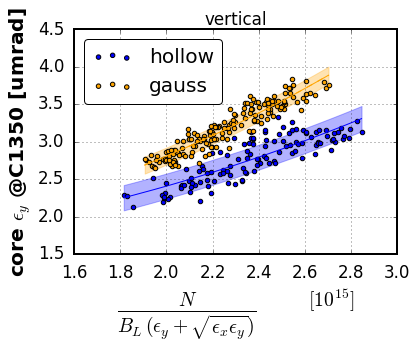

In [281]:
fig, ax = plt.subplots(1, 1, figsize=(6,5), sharex=True, sharey=True)

plt.sca(ax)
plt.xlabel(r'$\frac{N}{B_L \, (\epsilon_y + \sqrt{\epsilon_x \epsilon_y})}'
           '\qquad {}^{[10^{15}]}$',
          fontsize=28)# +
#            r'\propto \Delta Q_y^{SC}$' + ' '*8)
plt.ylabel('core $\epsilon_y$ @C1350 [umrad]')
plt.title('vertical')

# --- confidence intervals:

# from scipy.stats.distributions import t
# alpha = 1 - 0.95 # corresponds to 95% confidence level
# def fitfunc(x, c0, c2): return c0 + c2 * x**2
# def paramjacobian(x, c00cov, c02cov, c20cov, c22cov): 
#     return c00cov + (c02cov + c20cov) * x**2 #+ c22cov * x**4
# def fitfunc(x, c0, c1): return c0 + c1 * x
# def paramjacobian(x, c00cov, c01cov, c10cov, c11cov): 
#     return c00cov + (c01cov + c10cov) * x + c11cov * x**2

# # hollow ci
# xdata = dQy_hollow[rms_hollow_mask]
# ydata = 1e6*data_hollow['emit_y'][1][rms_hollow_mask]
# col = 'blue'

# # https://www.astro.rug.nl/software/kapteyn/
# # kmpfittutorial.html#confidence-and-prediction-intervals

# cs, cov = curve_fit(fitfunc, xdata, ydata)
# cs_hollow = cs

# dof = max(0, len(xdata) - len(cs))
# tval = t.ppf(1.0-alpha/2., dof)
# stderr = 1 #/ np.sqrt(len(xdata))
# reduced_chisq = dof**-1 * np.sum((ydata**2 - fitfunc(xdata, *cs))**2) / stderr**2
# reduced_chisq_hollow = reduced_chisq

# xminmax = np.linspace(np.min(xdata), np.max(xdata), num=100)
# yfitted = fitfunc(xminmax, *cs)
# yupperci = yfitted + tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))
# ylowerci = yfitted - tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))

# plt.plot(xminmax, yfitted, c=col)
# plt.plot(xminmax, ylowerci, c=col, alpha=0.5, ls='--')
# plt.plot(xminmax, yupperci, c=col, alpha=0.5, ls='--')

# plt.fill_between(xminmax, ylowerci, yupperci, color=col, alpha=0.3)

# # gauss ci
# xdata = dQy_gauss
# ydata = 1e6*data_gauss['emit_y'][1]
# col = 'orange'

# cs, cov = curve_fit(fitfunc, xdata, ydata)
# cs_gauss = cs

# dof = max(0, len(xdata) - len(cs))
# tval = t.ppf(1.0-alpha/2., dof)
# stderr = 1 #/ np.sqrt(len(xdata))
# reduced_chisq = dof**-1 * np.sum((ydata**2 - fitfunc(xdata, *cs))**2) / stderr**2
# reduced_chisq_gauss = reduced_chisq

# xminmax = np.linspace(np.min(xdata), np.max(xdata), num=100)
# yfitted = fitfunc(xminmax, *cs)
# yupperci = yfitted + tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))
# ylowerci = yfitted - tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))

# plt.plot(xminmax, yfitted, c=col)
# plt.plot(xminmax, ylowerci, c=col, alpha=0.5, ls='--')
# plt.plot(xminmax, yupperci, c=col, alpha=0.5, ls='--')

# plt.fill_between(xminmax, ylowerci, yupperci, color=col, alpha=0.3)

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    dQy_hollow[rms_hollow_mask], 1e6*data_hollow['emit_y'][1][rms_hollow_mask], 
    (dQy_hollow[rms_hollow_mask]**2,), conf_level_sigma=1, add_constant=True)
plt.plot(xdata_h, yfit_h, c='blue')
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.3)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    dQy_gauss, 1e6*data_gauss['emit_y'][1], (dQy_gauss**2,), 
    conf_level_sigma=1, add_constant=True)
plt.plot(xdata_g, yfit_g, c='orange')
plt.plot(xdata_g, yfit_g, c='orange', ls='--')
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.3)

# --- end of confidence intervals

plt.scatter(dQy_hollow[rms_hollow_mask],
            1e6*data_hollow['emit_y'][1][rms_hollow_mask], 
            c='blue', label='hollow')
plt.scatter(dQy_gauss, 1e6*data_gauss['emit_y'][1], c='orange', label='gauss')
plt.grid(True)
plt.legend(loc='best')
        
plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

# vbu_bf_hollow_fn = np.poly1d(np.polyfit(dQy_hollow[rms_hollow_mask], 
#                                         v_rmsblowup_hollow[rms_hollow_mask], 1))
# vbu_bf_gauss_fn = np.poly1d(np.polyfit(dQy_gauss, v_rmsblowup_gauss, 1))

# plt.plot(xlim, vbu_bf_hollow_fn(xlim), c='blue')
# plt.plot(xlim, vbu_bf_gauss_fn(xlim), c='orange')

# plt.xlim(xlim)
# plt.ylim(ylim);


plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/finalcoreemity_vs_nblemit.pdf');

In [283]:
print (results_g.params, results_h.params) 
# !! attention to the c0, they are quite reasonable!!

[ 1.50413183  0.32595356] [ 1.53004025  0.21925253]


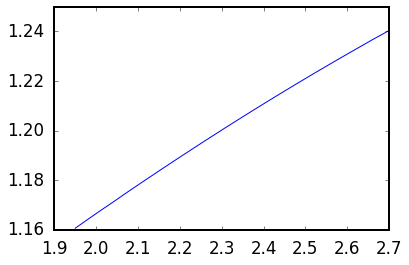

In [291]:
xdata_interp = np.linspace(1.95, 2.7, 100)
yfit_g_interp = np.interp(xdata_interp, xdata_g, yfit_g)
yfit_h_interp = np.interp(xdata_interp, xdata_h, yfit_h)

plt.plot(xdata_interp, yfit_g_interp / yfit_h_interp)

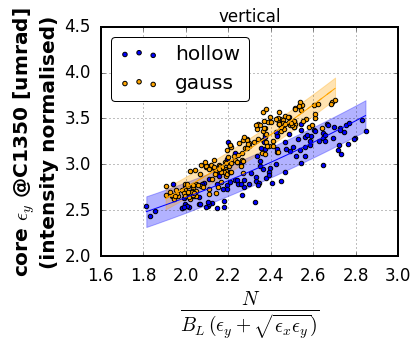

In [128]:
# refit vertical scale to intensity, should not be necessary!!!

gfac = 1.8e12/np.array(data_gauss['intensity'][0])#1.9
hfac = 1.8e12/np.array(data_hollow['intensity'][0])[rms_hollow_mask]#1.7
dQx_hollow = (
    data_hollow['intensity'][0] / data_hollow['bunchlength'][1] /
    (data_hollow['emit_x'][0] + 
     np.sqrt(data_hollow['emit_x'][0] * data_hollow['emit_y'][0]))
) * 1e-15
dQx_gauss = (
    data_gauss['intensity'][0] / data_gauss['bunchlength'][1] /
    (data_gauss['emit_x'][0] + 
     np.sqrt(data_gauss['emit_x'][0] * data_gauss['emit_y'][0]))
) * 1e-15

dQy_hollow = (
    data_hollow['intensity'][0] / data_hollow['bunchlength'][1] /
    (data_hollow['emit_y'][0] + 
     np.sqrt(data_hollow['emit_x'][0] * data_hollow['emit_y'][0]))
) * 1e-15
dQy_gauss = (
    data_gauss['intensity'][0] / data_gauss['bunchlength'][1] /
    (data_gauss['emit_y'][0] + 
     np.sqrt(data_gauss['emit_x'][0] * data_gauss['emit_y'][0]))
) * 1e-15

fig, ax = plt.subplots(1, 1, figsize=(6,5), sharex=True, sharey=True)

plt.sca(ax)
plt.xlabel(r'$\frac{N}{B_L \, (\epsilon_y + \sqrt{\epsilon_x \epsilon_y})}$',
          fontsize=28)# +
#            r'\propto \Delta Q_y^{SC}$' + ' '*8)
plt.ylabel('core $\epsilon_y$ @C1350 [umrad]\n(intensity normalised)')
plt.title('vertical')

# --- confidence intervals:

# from scipy.stats.distributions import t
# alpha = 1 - 0.95 # corresponds to 95% confidence level
# def fitfunc(x, c0, c2): return c0 + c2 * x**2
# def paramjacobian(x, c00cov, c02cov, c20cov, c22cov): 
#     return c00cov + (c02cov + c20cov) * x**2 + c22cov * x**4
# # def fitfunc(x, c0, c1): return c0 + c1 * x
# # def paramjacobian(x, c00cov, c01cov, c10cov, c11cov): 
# #     return c00cov + (c01cov + c10cov) * x + c11cov * x**2

# # hollow ci
# xdata = dQy_hollow[rms_hollow_mask]
# ydata = 1e6*data_hollow['emit_y'][1][rms_hollow_mask] * hfac
# col = 'blue'

# # https://www.astro.rug.nl/software/kapteyn/
# # kmpfittutorial.html#confidence-and-prediction-intervals

# cs, cov = curve_fit(fitfunc, xdata, ydata)
# cs_hollow = cs

# dof = max(0, len(xdata) - len(cs))
# tval = t.ppf(1.0-alpha/2., dof)
# stderr = 1 #/ np.sqrt(len(xdata))
# reduced_chisq = dof**-1 * np.sum((ydata**2 - fitfunc(xdata, *cs))**2) / stderr**2
# reduced_chisq_hollow = reduced_chisq

# xminmax = np.linspace(np.min(xdata), np.max(xdata), num=100)
# yfitted = fitfunc(xminmax, *cs)
# yupperci = yfitted + tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))
# ylowerci = yfitted - tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))

# plt.plot(xminmax, yfitted, c=col)
# # plt.plot(xminmax, ylowerci, c=col, alpha=0.5, ls='--')
# # plt.plot(xminmax, yupperci, c=col, alpha=0.5, ls='--')

# # plt.fill_between(xminmax, ylowerci, yupperci, color=col, alpha=0.3)

# # gauss ci
# xdata = dQy_gauss
# ydata = 1e6*data_gauss['emit_y'][1] * gfac
# col = 'orange'

# cs, cov = curve_fit(fitfunc, xdata, ydata)
# cs_gauss = cs

# dof = max(0, len(xdata) - len(cs))
# tval = t.ppf(1.0-alpha/2., dof)
# stderr = 1 #/ np.sqrt(len(xdata))
# reduced_chisq = dof**-1 * np.sum((ydata**2 - fitfunc(xdata, *cs))**2) / stderr**2
# reduced_chisq_gauss = reduced_chisq

# xminmax = np.linspace(np.min(xdata), np.max(xdata), num=100)
# yfitted = fitfunc(xminmax, *cs)
# yupperci = yfitted + tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))
# ylowerci = yfitted - tval * np.sqrt(reduced_chisq*paramjacobian(xminmax, *cov.flatten()))

# plt.plot(xminmax, yfitted, c=col)
# # plt.plot(xminmax, ylowerci, c=col, alpha=0.5, ls='--')
# # plt.plot(xminmax, yupperci, c=col, alpha=0.5, ls='--')

# # plt.fill_between(xminmax, ylowerci, yupperci, color=col, alpha=0.3)

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    dQy_hollow[rms_hollow_mask], 1e6*data_hollow['emit_y'][1][rms_hollow_mask] * hfac, 
    (dQy_hollow[rms_hollow_mask]**2,), conf_level_sigma=1, add_constant=True)
plt.plot(xdata_h, yfit_h, c='blue')
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.3)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    dQy_gauss, 1e6*data_gauss['emit_y'][1] * gfac, (dQy_gauss**2,), 
    conf_level_sigma=1, add_constant=True)
plt.plot(xdata_g, yfit_g, c='orange')
plt.plot(xdata_g, yfit_g, c='orange', ls='--')
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.3)

# --- end of confidence intervals

plt.scatter(dQy_hollow[rms_hollow_mask],
            1e6*data_hollow['emit_y'][1][rms_hollow_mask] * hfac, 
            c='blue', label='hollow')
plt.scatter(dQy_gauss, 1e6*data_gauss['emit_y'][1] * gfac, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc='best')
        
plt.tight_layout()

xlim = plt.xlim()
ylim = plt.ylim()

# vbu_bf_hollow_fn = np.poly1d(np.polyfit(dQy_hollow[rms_hollow_mask], 
#                                         v_rmsblowup_hollow[rms_hollow_mask], 1))
# vbu_bf_gauss_fn = np.poly1d(np.polyfit(dQy_gauss, v_rmsblowup_gauss, 1))

# plt.plot(xlim, vbu_bf_hollow_fn(xlim), c='blue')
# plt.plot(xlim, vbu_bf_gauss_fn(xlim), c='orange')

# plt.xlim(xlim)
# plt.ylim(ylim);

### remark: vertical tunes have not been equal...

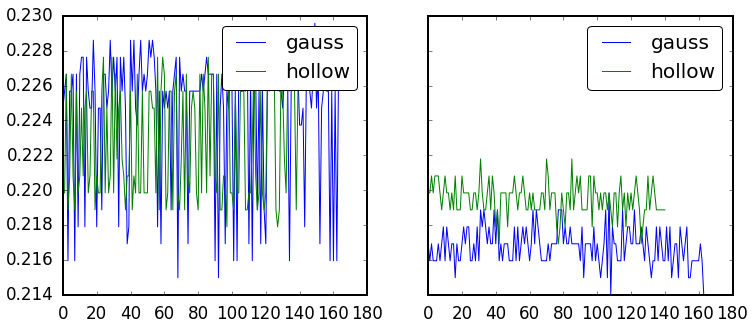

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(data_gauss['h_tune'], label='gauss')
plt.plot(data_hollow['h_tune'], label='hollow')
plt.legend()

plt.sca(ax[1])
plt.plot(data_gauss['v_tune'], label='gauss')
plt.plot(data_hollow['v_tune'], label='hollow')
plt.legend();

The horizontal tunes determination is spoiled because of uncorrected coupling. However, the horizontal tune was never changed during the experiments, so it should not have changed too much.

The vertical tunes however have been changed between the measurement set for the Gaussian and the hollow distributions (as there was the Gaussian vertical tune scan before the measurement set for the hollow distribution bunch length scan).

We should include the difference in vertical tunes between the two measurements in the PS: the distance of the (coherent dipolar) tune to the resonance allows for more or less room concerning space charge parameters.

## what actually are the tune shifts we are dealing with?

In [137]:
data = data_gauss

beta_x = 12.62
beta_y = 11.83
dd = {
    'peakcurrent': [data['peakcurrent'][0][0], data['peakcurrent'][1][0]],
    'std_x_stat': [data['std_x'][0][0]],
    'std_x': [np.sqrt(beta_x * data['emit_x'][0][0]/beta/gamma + 2.3**2 * data['deltap'][0][0]**2)],
    'std_y_stat': [data['std_y'][0][0]],
    'std_y': [np.sqrt(beta_y * data['emit_y'][0][0]/beta/gamma)],
#     'h_tune': data['h_tune'][0],
#     'v_tune': data['v_tune'][0],
    'intensity': [data['intensity'][0][0]],
    'eperimage': [data['eperimage'][0][0], data['eperimage'][1][0]],
    'deltap': [data['deltap'][0][0], data['deltap'][1][0]],
}

print ('horizontal beam sizes:')
print (dd['std_x_stat'][0], 'statistical standard deviation')
print (dd['std_x'][0], 'via Gaussian formula incl. dispersion term\n')
print ('vertical beam sizes:')
print (dd['std_y_stat'][0], 'statistical standard deviation')
print (dd['std_y'][0], 'via emittance')

horizontal beam sizes:
0.00468141358807 statistical standard deviation
0.00432073033702 via Gaussian formula incl. dispersion term

vertical beam sizes:
0.00382317337453 statistical standard deviation
0.00341391278844 via emittance


### rms emittances vs. core emittances

C185  rms/core = 1.23621478961 +- 0.0240014307107
C1350 rms/core = 1.14805964775 +- 0.0348776713305


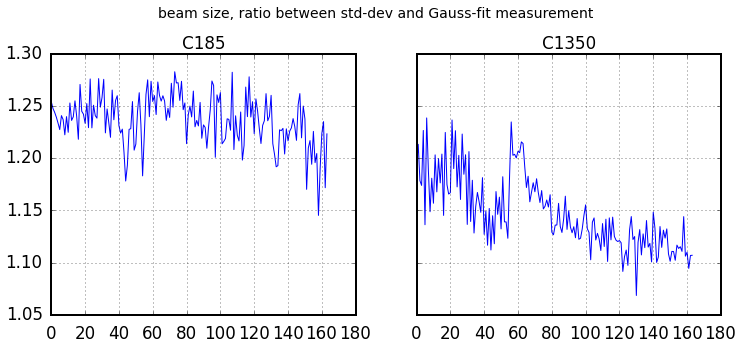

In [285]:
# gauss y
data = data_gauss
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.sca(ax[0])
plt.plot(data['std_y'][0]**2 / 11.83 / (data['emit_y'][0] / (beta*gamma)))
plt.title('C185')
plt.grid(True)
plt.sca(ax[1])
plt.plot(data['std_y'][1]**2 / 11.83 / (data['emit_y'][1] / (beta*gamma)))
plt.title('C1350')
plt.grid(True)
plt.subplots_adjust(top=0.85)
plt.suptitle('beam size, ratio between std-dev and Gauss-fit measurement')

print ("C185  rms/core =", 
       np.mean(data['std_y'][0]**2 / 11.83 / (data['emit_y'][0] / (beta*gamma))),
       "+-",
       np.std(data['std_y'][0]**2 / 11.83 / (data['emit_y'][0] / (beta*gamma))),)
print ("C1350 rms/core =", 
       np.mean(data['std_y'][1]**2 / 11.83 / (data['emit_y'][1] / (beta*gamma))),
       "+-",
       np.std(data['std_y'][1]**2 / 11.83 / (data['emit_y'][1] / (beta*gamma))),)

C185  rms/core = 1.30303881674 +- 0.0605487183099
C1350 rms/core = 1.24821169191 +- 0.0618016240951


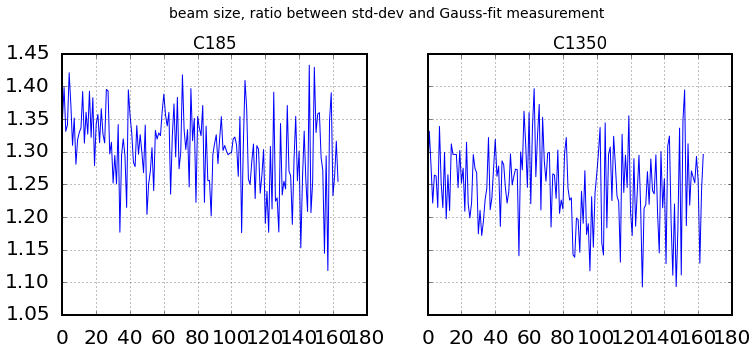

In [386]:
# gauss x
data = data_gauss
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.sca(ax[0])
plt.plot((data['std_x'][0]**2 - (2.3*data['deltap'][0])**2) / 11.83 / 
         (data['emit_x'][0] / (beta*gamma)))
plt.title('C185')
plt.grid(True)
plt.sca(ax[1])
plt.plot((data['std_x'][1]**2 - (2.3*data['deltap'][1])**2) / 11.83 / 
         (data['emit_x'][1] / (beta*gamma)))
plt.title('C1350')
plt.grid(True)
plt.subplots_adjust(top=0.85)
plt.suptitle('beam size, ratio between std-dev and Gauss-fit measurement')

print ("C185  rms/core =", 
       np.mean((data['std_x'][0]**2 - (2.3*data['deltap'][0])**2) / 11.83 / 
                (data['emit_x'][0] / (beta*gamma))),
       "+-",
       np.std((data['std_x'][0]**2 - (2.3*data['deltap'][0])**2) / 11.83 / 
              (data['emit_x'][0] / (beta*gamma))),)
print ("C1350 rms/core =", 
       np.mean((data['std_x'][1]**2 - (2.3*data['deltap'][1])**2) / 11.83 / 
               (data['emit_x'][1] / (beta*gamma))),
       "+-",
       np.std((data['std_x'][1]**2 - (2.3*data['deltap'][1])**2) / 11.83 / 
              (data['emit_x'][1] / (beta*gamma))),)

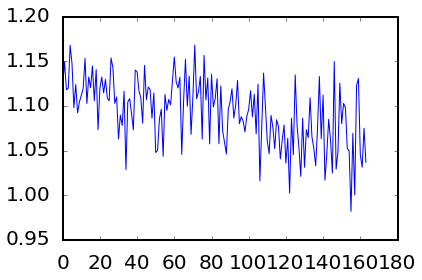

In [392]:
plt.plot(data_gauss['std_x'][0]**2 / data_gauss['core_sig_x'][0]**2)

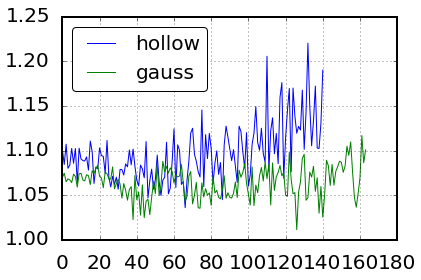

In [389]:
# plt.plot(data_hollow['emit_x'][0] / 
#          ((data_hollow['std_x'][0]**2 - disp_x**2 * data_hollow['deltap'][0]**2) / beta_x * beta * gamma))
# plt.plot(data_gauss['emit_x'][0] / 
#          ((data_gauss['std_x'][0]**2 - disp_x**2 * data_gauss['deltap'][0]**2) / beta_x * beta * gamma))

plt.plot(((data_hollow['core_sig_x'][0]**2 - 
           disp_x**2 * data_hollow['deltap'][0]**2) / beta_x * beta * gamma) /
         data_hollow['emit_x'][0],
        label='hollow')
plt.plot(((data_gauss['core_sig_x'][0]**2 - 
           disp_x**2 * data_gauss['deltap'][0]**2) / beta_x * beta * gamma) /
         data_gauss['emit_x'][0],
        label='gauss')
plt.grid(True);
plt.legend(loc=2);

C185  rms/core = 1.29358684182 +- 0.0424812510201
C1350 rms/core = 1.21522713055 +- 0.0588033485175


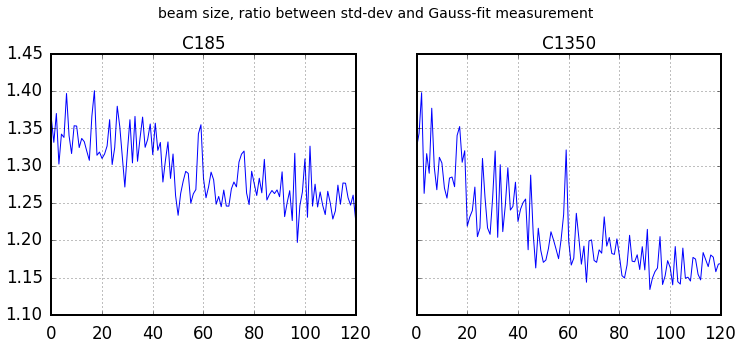

In [288]:
# hollow y
data = data_hollow
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.sca(ax[0])
plt.plot(data['std_y'][0][rms_hollow_mask]**2 / 11.83 / 
         (data['emit_y'][0][rms_hollow_mask] / (beta*gamma)))
plt.title('C185')
plt.grid(True)
plt.sca(ax[1])
plt.plot(data['std_y'][1][rms_hollow_mask]**2 / 11.83 / 
         (data['emit_y'][1][rms_hollow_mask] / (beta*gamma)))
plt.title('C1350')
plt.grid(True)
plt.subplots_adjust(top=0.85)
plt.suptitle('beam size, ratio between std-dev and Gauss-fit measurement')

print ("C185  rms/core =", 
       np.mean(data['std_y'][0][rms_hollow_mask]**2 / 11.83 / 
               (data['emit_y'][0][rms_hollow_mask] / (beta*gamma))),
       "+-",
       np.std(data['std_y'][0][rms_hollow_mask]**2 / 11.83 / 
              (data['emit_y'][0][rms_hollow_mask] / (beta*gamma))),)
print ("C1350 rms/core =", 
       np.mean(data['std_y'][1][rms_hollow_mask]**2 / 11.83 / 
               (data['emit_y'][1][rms_hollow_mask] / (beta*gamma))),
       "+-",
       np.std(data['std_y'][1][rms_hollow_mask]**2 / 11.83 / 
              (data['emit_y'][1][rms_hollow_mask] / (beta*gamma))),)

C185  rms/core = 1.34839805267 +- 0.0670500873012
C1350 rms/core = 1.28046907511 +- 0.0740703790383


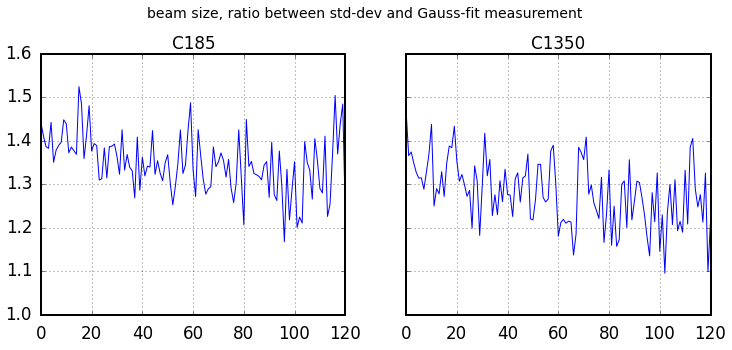

In [292]:
# hollow x
data = data_hollow
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
plt.sca(ax[0])
plt.plot((data['std_x'][0][rms_hollow_mask]**2 - (2.3*data['deltap'][0][rms_hollow_mask])**2) / 11.83 / 
         (data['emit_x'][0][rms_hollow_mask] / (beta*gamma)))
plt.title('C185')
plt.grid(True)
plt.sca(ax[1])
plt.plot((data['std_x'][1][rms_hollow_mask]**2 - (2.3*data['deltap'][1][rms_hollow_mask])**2) / 11.83 / 
         (data['emit_x'][1][rms_hollow_mask] / (beta*gamma)))
plt.title('C1350')
plt.grid(True)
plt.subplots_adjust(top=0.85)
plt.suptitle('beam size, ratio between std-dev and Gauss-fit measurement')

print ("C185  rms/core =", 
       np.mean((data['std_x'][0][rms_hollow_mask]**2 - (2.3*data['deltap'][0][rms_hollow_mask])**2) / 11.83 / 
                (data['emit_x'][0][rms_hollow_mask] / (beta*gamma))),
       "+-",
       np.std((data['std_x'][0][rms_hollow_mask]**2 - (2.3*data['deltap'][0][rms_hollow_mask])**2) / 11.83 / 
              (data['emit_x'][0][rms_hollow_mask] / (beta*gamma))),)
print ("C1350 rms/core =", 
       np.mean((data['std_x'][1][rms_hollow_mask]**2 - (2.3*data['deltap'][1][rms_hollow_mask])**2) / 11.83 / 
               (data['emit_x'][1][rms_hollow_mask] / (beta*gamma))),
       "+-",
       np.std((data['std_x'][1][rms_hollow_mask]**2 - (2.3*data['deltap'][1][rms_hollow_mask])**2) / 11.83 / 
              (data['emit_x'][1][rms_hollow_mask] / (beta*gamma))),)

In [174]:
from scipy.constants import m_p, m_e
r_p = 2.8179403267e-15 *m_e/m_p

def tstool_ext_calc_tune_spread(data, inputs, f_verbose=False):
    """Calculates the (maximum) tune shift DeltaQ_x and DeltaQ_y due
    to space charge with given optics parameters provided by
    the dictionaries / hash tables <i>inputs</i> and <i>data</i>.
    """
#     std_x_div_by_Dx is the horizontal profile's standard deviation
#     divided by the horizontal dispersion at that point. 
#     Equivalently for the vertical plane with std_y_div_by_Dy.
    r = r_p
    beta = inputs["beta"]
    gamma = inputs["gamma"]
    n_part = inputs["n_part"]
    emit_x = inputs["emit_geom_x"]
    emit_y = inputs["emit_geom_y"]
    lshape = inputs.get("lshape", 1.)
    std_x_div_by_Dx = inputs["std_x_div_by_Dx"]
    integx = integy = 0
    
    ds = np.diff(data["s"])
    beta_x = data["beta_x"][:-1]
    beta_y = data["beta_y"][:-1]
    d_x = data["d_x"][:-1]

    # dispersion only scales the convolution (joint PDF of x = x_beta + D_x * dp)
    sqx = std_x_div_by_Dx * d_x
    sqy = np.sqrt(emit_y * beta_y)
    integx = np.sum(beta_x * ds / (sqx * (sqx + sqy)))
    integy = np.sum(beta_y * ds / (sqy * (sqx + sqy)))
    
    prefactor = r * n_part / (2.0 * np.pi * beta**2 * gamma**3)
    if inputs.get('coasting', False):
        circumference = data["s"][-1]
        shapefactor = lshape / circumference
    else:
        # assume Gaussian shape
        shapefactor = lshape / (np.sqrt(2.0 * np.pi) * inputs["sig_z"])
    DeltaQ_x = prefactor * shapefactor * integx
    DeltaQ_y = prefactor * shapefactor * integy

    return (DeltaQ_x, DeltaQ_y)

In [175]:
def calc_dQ_tunespreadtool(
        data, mass=m_p, beta=beta, gamma=gamma, 
        ws_beta_y=11.83, ws_disp_x=2.3, use_long_gauss=False,
        extended_Dx_part=False, use_std_not_core_sigx=True):
    '''Return the maximum transverse Gaussian tune shift.
    If use_long_gauss is True, the formula assuming
    Gaussian longitudinal shape is used instead of
    evaluating the real maximum line density.
    '''
    
    with open('/home/oeftiger/cern/git/oeftiger/'
              'tunespreadtool/PS-inj2GeV-data.tfs', 'r') as f:
        for _ in xrange(52): f.readline()
        labels = f.readline().split()[1:]
        f.readline()
        twiss_data = np.genfromtxt(f, unpack=True)
    
    with open('/home/oeftiger/cern/git/oeftiger/'
              'tunespreadtool/PS-inj2GeV-s.tfs', 'r') as f:
        for _ in xrange(52): f.readline()
        labels += f.readline().split()[1:]
        f.readline()
        f_twiss_data = np.genfromtxt(f, unpack=True)
    
    twiss_data = np.vstack((twiss_data, f_twiss_data))
        
    tst_data = {var.lower(): array for var, array in zip(labels, twiss_data)}
    tst_data['beta_x'] = tst_data.pop('beta11')
    tst_data['beta_y'] = tst_data.pop('beta22')
    tst_data['d_x'] = tst_data.pop('disp1') * beta
    tst_data['d_y'] = tst_data.pop('disp2') * beta
    circumference = tst_data['s'][-1]
    
    # tunespreadtool, attention: need to use numpy arrays
    def make_tst_inputs(intensity, deltap, emit_geo_x, emit_geo_y, 
                        sig_z, std_x_div_by_Dx):
        return dict(
            mass=(mass * c**2/e * 1e-9),
            beta=beta,
            gamma=gamma,
            sig_z=sig_z,
            n_part=intensity,
            deltap=deltap,
            emit_geom_x=emit_geo_x,
            emit_geom_y=emit_geo_y,
            coasting=not use_long_gauss,
            n_charges_per_part=1,
            std_x_div_by_Dx=std_x_div_by_Dx,
        )
    make_tst_inputs = np.vectorize(make_tst_inputs)
    if not extended_Dx_part:
        calc_tune_spread = np.vectorize(
            lambda tst_inputs: tunespread.calc_tune_spread(
                tst_data, tst_inputs, False) 
        )
    else:
        calc_tune_spread = np.vectorize(
            lambda tst_inputs: tstool_ext_calc_tune_spread(
                tst_data, tst_inputs, False) 
        )
    
    lambda_max_norm = data['peakcurrent'][1] / (beta * c * e) / data['eperimage'][0]
    
    tst_inputs = make_tst_inputs(
        np.array(data['intensity'][0]),
        data['deltap'][1],
        data['emit_x'][0] / (beta*gamma),
        data['std_y'][0]**2 / ws_beta_y,
#         data['emit_y'][0] / (beta*gamma)
        data['bunchlength'][1]*1e-9 / 4 * beta * c,
#         data['std_x'][0] / ws_disp_x,
        data['std_x' if use_std_not_core_sigx else 'core_sig_x'][0] / ws_disp_x,
    )
    
    if use_long_gauss:
        tst_dQ_x, tst_dQ_y = calc_tune_spread(tst_inputs)
    else:
        tst_dQ_x, tst_dQ_y = (circumference * lambda_max_norm * 
                              calc_tune_spread(tst_inputs))
    return tst_dQ_x, tst_dQ_y

for data in (data_hollow, data_gauss):
    data['dQx'], data['dQy'] = calc_dQ_tunespreadtool(data)
    data['dQx_fakeGauss'], data['dQy_fakeGauss'] = \
        calc_dQ_tunespreadtool(data, use_long_gauss=True)

    data['dQx_disp'], data['dQy_disp'] = calc_dQ_tunespreadtool(
        data, extended_Dx_part=True)
    data['dQx_disp_fakeGauss'], data['dQy_disp_fakeGauss'] = \
        calc_dQ_tunespreadtool(data, extended_Dx_part=True, 
                               use_long_gauss=True)
        
    data['dQx_disp_core'], data['dQy_disp_core'] = calc_dQ_tunespreadtool(
        data, extended_Dx_part=True, use_std_not_core_sigx=False)
    data['dQx_disp_core_fakeGauss'], data['dQy_disp_core_fakeGauss'] = \
        calc_dQ_tunespreadtool(data, extended_Dx_part=True, 
                               use_long_gauss=True, use_std_not_core_sigx=False)

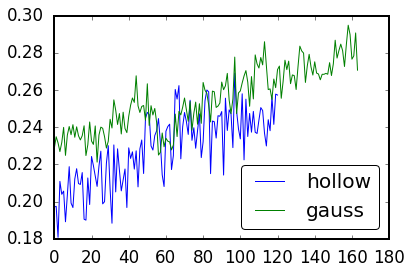

In [131]:
plt.plot(data_hollow['dQy'][rms_hollow_mask], label='hollow')
plt.plot(data_gauss['dQy'], label='gauss')
plt.legend(loc=4);

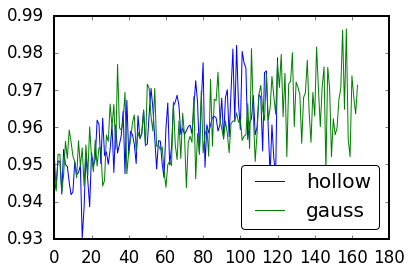

In [132]:
plt.plot(data_hollow['dQy_disp'][rms_hollow_mask]/
         data_hollow['dQy'][rms_hollow_mask], label='hollow')
plt.plot(data_gauss['dQy_disp']/data_gauss['dQy'], label='gauss')
plt.legend(loc=4);

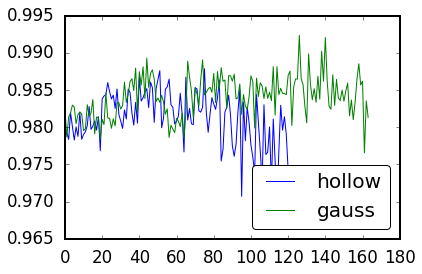

In [133]:
plt.plot(data_hollow['dQy_disp_core'][rms_hollow_mask]/
         data_hollow['dQy'][rms_hollow_mask], label='hollow')
plt.plot(data_gauss['dQy_disp_core']/data_gauss['dQy'], label='gauss')
plt.legend(loc=4);

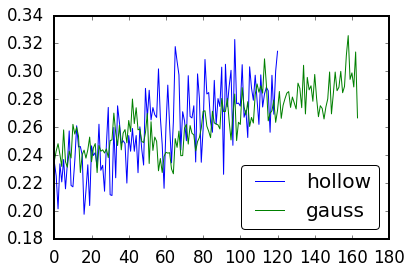

In [134]:
plt.plot(data_hollow['dQy_fakeGauss'][rms_hollow_mask], label='hollow')
plt.plot(data_gauss['dQy_fakeGauss'], label='gauss')
plt.legend(loc=4);

How far are we away from longitudinal Gaussian distribution?

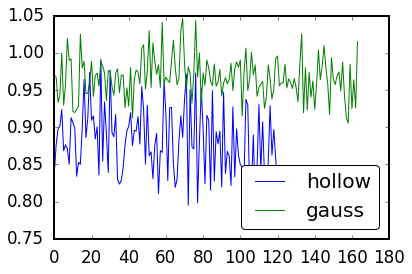

In [135]:
plt.plot(data_hollow['dQy'][rms_hollow_mask]/
         data_hollow['dQy_fakeGauss'][rms_hollow_mask], label='hollow')
plt.plot(data_gauss['dQy']/data_gauss['dQy_fakeGauss'], label='gauss')
plt.legend(loc=4);

Comparing the real tune spread does not really help us:

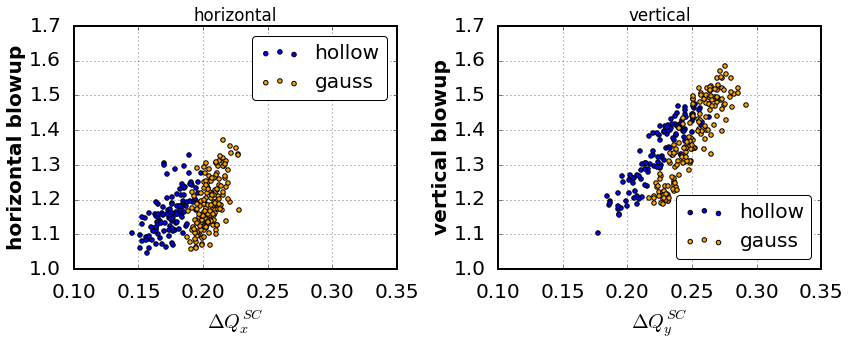

In [544]:
h_tune = 0.225

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(#-data_hollow['dQx'] + h_tune, 
            data_hollow['dQx_disp_core'][rms_hollow_mask],
            h_blowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQx'] + h_tune, 
            data_gauss['dQx_disp_core'],
            h_blowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.xlabel(r'$\Delta Q_x^{SC}$')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(#-data_hollow['dQy'] + data_hollow['v_tune'], 
            data_hollow['dQy_disp_core'][rms_hollow_mask],
            v_blowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQy'] + data_gauss['v_tune'], 
            data_gauss['dQy_disp_core'],
            v_blowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel(r'$\Delta Q_y^{SC}$')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

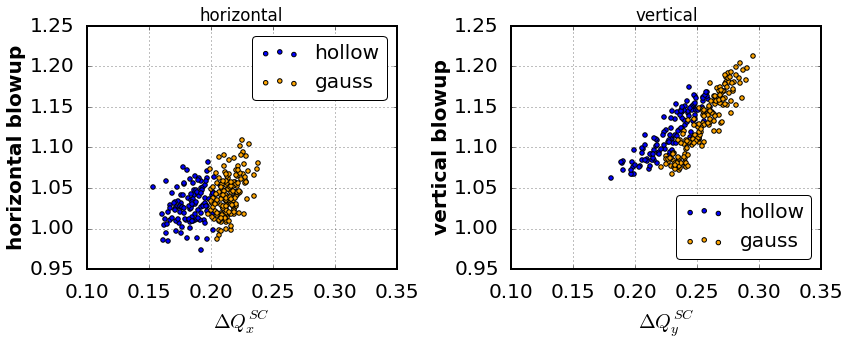

In [545]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(#-data_hollow['dQx'] + h_tune, 
            data_hollow['dQx'][rms_hollow_mask],
            h_rmsblowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQx'] + h_tune, 
            data_gauss['dQx'],
            h_rmsblowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.xlabel(r'$\Delta Q_x^{SC}$')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(#-data_hollow['dQy'] + data_hollow['v_tune'], 
            data_hollow['dQy'][rms_hollow_mask],
            v_rmsblowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQy'] + data_gauss['v_tune'], 
            data_gauss['dQy'],
            v_rmsblowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel(r'$\Delta Q_y^{SC}$')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

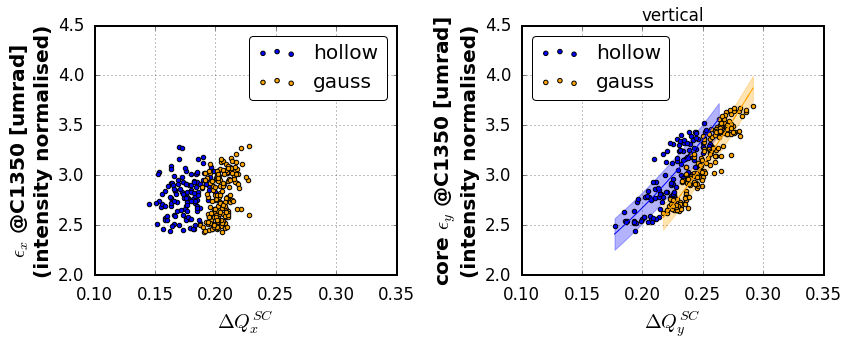

In [138]:
# refit vertical scale to intensity, should not be necessary!!!

# h_tune = 0.225

gfac = 1.8e12/np.array(data_gauss['intensity'][0])#1.9
hfac = 1.8e12/np.array(data_hollow['intensity'][0])[rms_hollow_mask]#1.7

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(#-data_hollow['dQx'] + h_tune, 
            data_hollow['dQx_disp_core'][rms_hollow_mask],
            1e6*data_hollow['emit_x'][1][rms_hollow_mask] * hfac, 
            c='blue', label='hollow')
plt.scatter(#-data_gauss['dQx'] + h_tune, 
            data_gauss['dQx_disp_core'],
            1e6*data_gauss['emit_x'][1] * gfac, c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.ylabel('$\epsilon_x$ @C1350 [umrad]\n(intensity normalised)')
plt.xlabel(r'$\Delta Q_x^{SC}$')

plt.sca(ax[1])

# --- confidence intervals:

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    data_hollow['dQy_disp_core'][rms_hollow_mask], 
    1e6*data_hollow['emit_y'][1][rms_hollow_mask] * hfac, 
    (data_hollow['dQy_disp_core'][rms_hollow_mask]**2,), 
    conf_level_sigma=1, add_constant=True)
plt.plot(xdata_h, yfit_h, c='blue')
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.3)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    data_gauss['dQy_disp_core'], 1e6*data_gauss['emit_y'][1] * gfac, 
    (data_gauss['dQy_disp_core']**2,), 
    conf_level_sigma=1, add_constant=True)
plt.plot(xdata_g, yfit_g, c='orange')
plt.plot(xdata_g, yfit_g, c='orange', ls='--')
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.3)

# --- end of confidence intervals

plt.scatter(#-data_hollow['dQy'] + data_hollow['v_tune'], 
            data_hollow['dQy_disp_core'][rms_hollow_mask],
            1e6*data_hollow['emit_y'][1][rms_hollow_mask] * hfac, 
            c='blue', label='hollow')
plt.scatter(#-data_gauss['dQy'] + data_gauss['v_tune'], 
            data_gauss['dQy_disp_core'],
            1e6*data_gauss['emit_y'][1] * gfac, 
            c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=2)
plt.ylabel('core $\epsilon_y$ @C1350 [umrad]\n(intensity normalised)')
plt.xlabel(r'$\Delta Q_y^{SC}$')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

In [140]:
print (results_g.params, results_h.params)

[  0.96644677  34.22044959] [  1.46176304  30.38183898]


influence of stopband width depending on Gaussian / hollow distribution via chromaticity 
and dispersion / differen momentum distribution leading to offset in skew sextupole position

If instead of the lambda_max formula (which would compare the real estimate for the maximal tune shift) we use the bunch length formula which would assume a Gaussian tune shift given a sig_z, we get the following plot:

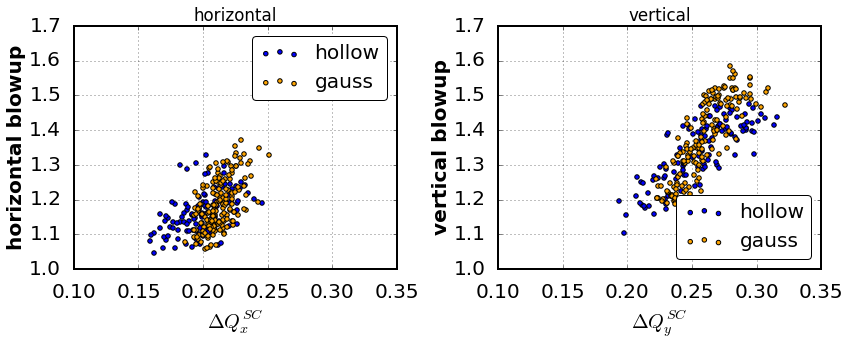

In [549]:
h_tune = 0.225

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(#-data_hollow['dQx'] + h_tune, 
            data_hollow['dQx_disp_core_fakeGauss'][rms_hollow_mask],
            h_blowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQx'] + h_tune, 
            data_gauss['dQx_disp_core_fakeGauss'],
            h_blowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.xlabel(r'$\Delta Q_x^{SC}$')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(#-data_hollow['dQy'] + data_hollow['v_tune'], 
            data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask],
            v_blowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQy'] + data_gauss['v_tune'], 
            data_gauss['dQy_disp_core_fakeGauss'],
            v_blowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel(r'$\Delta Q_y^{SC}$')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

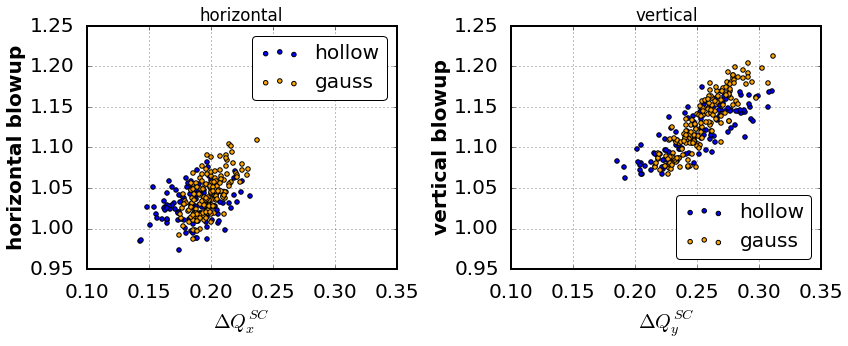

In [551]:
h_tune = 0.225

fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)

plt.sca(ax[0])
plt.scatter(#-data_hollow['dQx'] + h_tune, 
            data_hollow['dQx_disp_fakeGauss'][rms_hollow_mask],
            h_rmsblowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQx'] + h_tune, 
            data_gauss['dQx_disp_fakeGauss'],
            h_rmsblowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend()
plt.xlabel(r'$\Delta Q_x^{SC}$')
plt.ylabel('horizontal blowup')
plt.title('horizontal')

plt.sca(ax[1])
plt.scatter(#-data_hollow['dQy'] + data_hollow['v_tune'], 
            data_hollow['dQy_disp_fakeGauss'][rms_hollow_mask],
            v_rmsblowup_hollow[rms_hollow_mask], c='blue', label='hollow')
plt.scatter(#-data_gauss['dQy'] + data_gauss['v_tune'], 
            data_gauss['dQy_disp_fakeGauss'],
            v_rmsblowup_gauss, c='orange', label='gauss')
plt.grid(True)
plt.legend(loc=4)
plt.xlabel(r'$\Delta Q_y^{SC}$')
plt.ylabel('vertical blowup')
plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
plt.tight_layout()

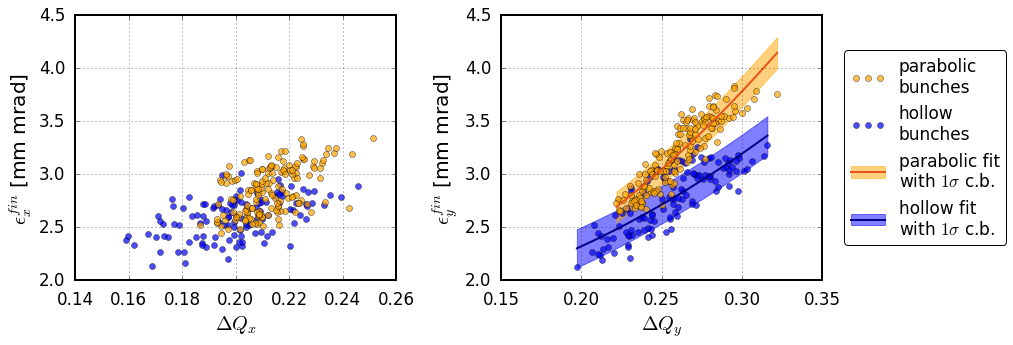

In [430]:
h_tune = 0.225

data_tbp_hx = 1e6*np.array(data_hollow['emit_x'][1])[rms_hollow_mask]
data_tbp_gx = 1e6*np.array(data_gauss['emit_x'][1])
data_tbp_hy = 1e6*np.array(data_hollow['emit_y'][1])[rms_hollow_mask]
data_tbp_gy = 1e6*np.array(data_gauss['emit_y'][1])
# data_tbp_hx = h_blowup_hollow[rms_hollow_mask]
# data_tbp_gx = h_blowup_gauss
# data_tbp_hy = v_blowup_hollow[rms_hollow_mask]
# data_tbp_gy = v_blowup_gauss

fig, ax = plt.subplots(1, 2, figsize=(12,5), 
#                        sharex=True, 
                       sharey=True)

plt.sca(ax[0])

plt.plot(
    data_hollow['dQx_disp_core_fakeGauss'][rms_hollow_mask],
    data_tbp_hx,
    c='blue', marker='o', ls='None', label='hollow', alpha=0.7)
plt.plot(
    data_gauss['dQx_disp_core_fakeGauss'],
    data_tbp_gx,
    c='orange', marker='o', ls='None', label='Gauss', alpha=0.7)

plt.grid(True)
# plt.legend(loc=2, fontsize=17)
# plt.xlabel(r'$\Delta Q_x^{SC}$ for longit. Gauss')
# plt.ylabel('horizontal emittance\n $\epsilon_x$ @C1350 [umrad]')
plt.xlabel(r'$\Delta Q_x$')
plt.ylabel(r'$\epsilon_x^{fin}$ [mm mrad]', fontweight=None)
# plt.ylabel(r'horizontal core blow-up', fontweight=None)

plt.sca(ax[1])

hollowscatter, = plt.plot(
    data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask],
    data_tbp_hy,
    c='blue', marker='o', ls='None', label='hollow', alpha=0.7)
gaussscatter, = plt.plot(
    data_gauss['dQy_disp_core_fakeGauss'],
    data_tbp_gy,
    c='orange', marker='o', ls='None', label='Gauss', alpha=0.7)

# --- confidence intervals:

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask], 
    data_tbp_hy, 
    (data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask]**2,), 
    conf_level_sigma=1, add_constant=True)
hollowfitline, = plt.plot(xdata_h, yfit_h, c='darkblue' ,lw=2)
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.5)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    data_gauss['dQy_disp_core_fakeGauss'], 
    data_tbp_gy, 
    (data_gauss['dQy_disp_core_fakeGauss']**2,), 
    conf_level_sigma=1, add_constant=True)
gaussfitline, = plt.plot(xdata_g, yfit_g, c='#e6541a', lw=2)
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.5)

# --- end of confidence intervals

plt.grid(True)
# plt.legend(loc=2, fontsize=17)
# plt.xlabel(r'$\Delta Q_y^{SC}$ for longit. Gauss')
# plt.ylabel('vertical core emittance\n $\epsilon_y$ @C1350 [umrad]')
plt.xlabel(r'$\Delta Q_y$')
plt.ylabel(r'$\epsilon_y^{fin}$ [mm mrad]', fontweight=None)
# plt.ylabel(r'vertical core blow-up', fontweight='normal')

plt.xlim(0.15, 0.35)

plt.ylim(2, 4.5)
# plt.ylim(1, 1.8)

# plt.title('vertical')

for axis in ax.flatten():
    for tk in axis.get_yticklabels():
        tk.set_visible(True)
    for tk in axis.get_xticklabels():
        tk.set_visible(True)
        
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

class FitHandler(object):
    def __init__(self, patch_color, line_color):
        self.patch_color = patch_color
        self.line_color = line_color
        
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        patch = mpatches.Rectangle(
            [x0, y0], width, height, color=self.patch_color, alpha=0.5,
            transform=handlebox.get_transform())
        line = mlines.Line2D(
            [x0, x0 + width], [y0 + height/2., y0 + height/2.], 
            color=self.line_color, lw=2)
        handlebox.add_artist(patch)
        handlebox.add_artist(line)
        return patch

plt.legend(
    [gaussscatter, hollowscatter,
     gaussfitline, hollowfitline],
    ['parabolic\nbunches', 'hollow\nbunches',
     'parabolic fit\n' + r'with $1\sigma$ c.b.', 
     'hollow fit\n' + r'with $1\sigma$ c.b.'],
    handler_map={gaussfitline: FitHandler('orange', '#e6541a'),
                 hollowfitline: FitHandler('blue', 'darkblue')},
    numpoints=3,
    fontsize=17,
    bbox_to_anchor=(1.6, 0.9)
#     loc='center', 
)

plt.tight_layout()

plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
            'images/ch5_hollow_bunches/finalcoreemit_vs_dQ.pdf',
           bbox_inches='tight')

# plt.savefig('/home/oeftiger/cern/documents/latex/'
#             '16-04-06-IPAC-hollow-bunches/images/'
#             'finalcoreemit_vs_dQ.pdf')

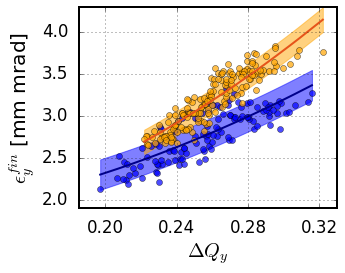

In [240]:
h_tune = 0.225

# fig, ax = plt.subplots(1, 2, figsize=(12,5), sharex=True, sharey=True)
plt.figure(figsize=(5,4))

# plt.sca(ax[0])
# plt.plot(#-data_hollow['dQx'] + h_tune, 
#             data_hollow['dQx_disp_core_fakeGauss'][rms_hollow_mask],
#             1e6*np.array(data_hollow['emit_x'][1])[rms_hollow_mask], 
#             c='blue', marker='o', ls='None', label='hollow', alpha=0.7)
# plt.plot(#-data_gauss['dQx'] + h_tune, 
#             data_gauss['dQx_disp_core_fakeGauss'],
#             1e6*np.array(data_gauss['emit_x'][1]), 
# #             c='orange', label='gauss')
#             c='orange', marker='o', ls='None', label='Gauss', alpha=0.7)
# plt.grid(True)
# plt.legend(loc=2, fontsize=17)
# # plt.xlabel(r'$\Delta Q_x^{SC}$ for longit. Gauss')
# # plt.ylabel('horizontal emittance\n $\epsilon_x$ @C1350 [umrad]')
# plt.xlabel(r'$\Delta Q_x$')
# plt.ylabel(r'$\epsilon_x^{fin}$ [mm mrad]', fontweight=None)
# # plt.title('horizontal')

# plt.sca(ax[1])

plt.plot(#-data_hollow['dQy'] + data_hollow['v_tune'], 
            data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask],
            1e6*np.array(data_hollow['emit_y'][1])[rms_hollow_mask], 
            c='blue', marker='o', ls='None', label='hollow', alpha=0.7)
plt.plot(#-data_gauss['dQy'] + data_gauss['v_tune'], 
            data_gauss['dQy_disp_core_fakeGauss'],
            1e6*np.array(data_gauss['emit_y'][1]), 
#             c='orange', label='gauss')
            c='orange', marker='o', ls='None', label='Gauss', alpha=0.7)

# --- confidence intervals:

xdata_h, yfit_h, yl_ci_h, yu_ci_h, results_h = fit_with_ci(
    data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask], 
    1e6*data_hollow['emit_y'][1][rms_hollow_mask], 
    (data_hollow['dQy_disp_core_fakeGauss'][rms_hollow_mask]**2,), 
    conf_level_sigma=1, add_constant=True)
plt.plot(xdata_h, yfit_h, c='darkblue' ,lw=2)
plt.fill_between(xdata_h, yl_ci_h, yu_ci_h, color='blue', alpha=0.5)

xdata_g, yfit_g, yl_ci_g, yu_ci_g, results_g = fit_with_ci(
    data_gauss['dQy_disp_core_fakeGauss'], 1e6*data_gauss['emit_y'][1], 
    (data_gauss['dQy_disp_core_fakeGauss']**2,), 
    conf_level_sigma=1, add_constant=True)
plt.plot(xdata_g, yfit_g, c='#e6541a', lw=2)
plt.fill_between(xdata_g, yl_ci_g, yu_ci_g, color='orange', alpha=0.5)

# --- end of confidence intervals

plt.grid(True)
# plt.legend(loc=2, fontsize=17)
# plt.xlabel(r'$\Delta Q_y^{SC}$ for longit. Gauss')
# plt.ylabel('vertical core emittance\n $\epsilon_y$ @C1350 [umrad]')
plt.xlabel(r'$\Delta Q_y$')
plt.ylabel(r'$\epsilon_y^{fin}$ [mm mrad]', fontweight=None)

plt.xlim(0.185, 0.33)
plt.ylim(1.9, 4.3)

# plt.title('vertical')

plt.gca().set_xticks([0.2, 0.24, 0.28, 0.32])
        
plt.tight_layout()

# plt.savefig('/home/oeftiger/cern/documents/latex/phd-thesis/main/'
#             'images/ch5_hollow_bunches/finalcoreemit_vs_dQ.pdf')

# plt.savefig('/home/oeftiger/cern/documents/latex/'
#             '16-04-06-IPAC-hollow-bunches/images/'
#             'finalcorevertemit_vs_dQ.pdf')

In [297]:
print (results_g.params, results_h.params)

[  1.37727654  26.72555807] [  1.61845893  17.51981276]


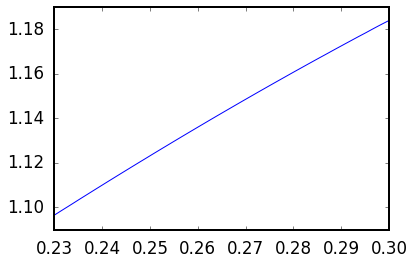

In [295]:
xdata_interp = np.linspace(0.23, 0.3, 100)
yfit_g_interp = np.interp(xdata_interp, xdata_g, yfit_g)
yfit_h_interp = np.interp(xdata_interp, xdata_h, yfit_h)

plt.plot(xdata_interp, yfit_g_interp / yfit_h_interp)

In [267]:
xdata_gx, yfit_gx, yl_ci_gx, yu_ci_gx, results_gx = fit_with_ci(
    data_gauss['dQx_disp_core_fakeGauss'], 1e6*data_gauss['emit_x'][1], 
    (data_gauss['dQx_disp_core_fakeGauss']**2,), 
    conf_level_sigma=1, add_constant=True)

In [277]:
xdata_gx[23]

0.20018130756521943

In [280]:
psb_emit_x = 2.229
psb_emit_y = 2.118

print (
    "for a dQ_y =\n",xdata_g[159], 
    "\nwe find a vertically fit epsn_y =\n", yfit_g[159]
)
print (
    "while for a dQ_x =\n", xdata_gx[23],
    "\nwe find a horizontally fit epsn_x =\n", yfit_gx[23],
)
print (
    "\nyielding a transverse blow-up of\n", 
    (yfit_g[159] + yfit_gx[23]) / (psb_emit_x + psb_emit_y)
)

for a dQ_y =
 0.299867752886 
we find a vertically fit epsn_y =
 3.78045660486
while for a dQ_x =
 0.200181307565 
we find a horizontally fit epsn_x =
 2.73065573896

yielding a transverse blow-up of
 1.49784042876


what's the difference between the real dQy and the Gauss dQy?

In [190]:
print (
    'extrema ratios',
    np.min(data_hollow['dQy_disp_core']) / np.min(data_hollow['dQy_disp_core_fakeGauss']),
    np.max(data_hollow['dQy_disp_core']) / np.max(data_hollow['dQy_disp_core_fakeGauss']),
    np.min(data_gauss['dQy_disp_core']) / np.min(data_gauss['dQy_disp_core_fakeGauss']),
    np.max(data_gauss['dQy_disp_core']) / np.max(data_gauss['dQy_disp_core_fakeGauss']),
)
print (
    'means of all ratios',
    np.mean(data_hollow['dQy_disp_core'] / 
            data_hollow['dQy_disp_core_fakeGauss']),
    np.mean(data_gauss['dQy_disp_core'] / 
            data_gauss['dQy_disp_core_fakeGauss'])
)

extrema ratios 0.897301949872 0.835821218847 0.978919020738 0.905332607246
means of all ratios 0.87868492728 0.967069781612


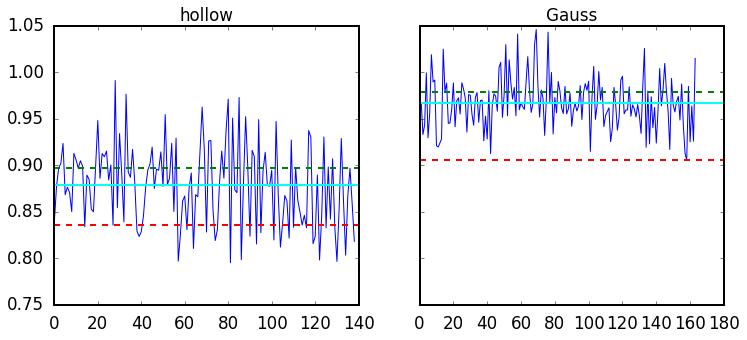

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)

plt.sca(ax[0])
plt.plot(data_hollow['dQy_disp_core'] / data_hollow['dQy_disp_core_fakeGauss'])
plt.axhline(np.min(data_hollow['dQy_disp_core']) / 
            np.min(data_hollow['dQy_disp_core_fakeGauss']),
            color='green', lw=2, ls='--')
plt.axhline(np.max(data_hollow['dQy_disp_core']) / 
            np.max(data_hollow['dQy_disp_core_fakeGauss']),
            color='red', lw=2, ls='--')
plt.axhline(np.mean(data_hollow['dQy_disp_core'] / 
                    data_hollow['dQy_disp_core_fakeGauss']),
            color='cyan', lw=2)
plt.title('hollow')

plt.sca(ax[1])
plt.plot(data_gauss['dQy_disp_core'] / data_gauss['dQy_disp_core_fakeGauss'])
plt.axhline(np.min(data_gauss['dQy_disp_core']) / 
            np.min(data_gauss['dQy_disp_core_fakeGauss']),
            color='green', lw=2, ls='--')
plt.axhline(np.max(data_gauss['dQy_disp_core']) / 
            np.max(data_gauss['dQy_disp_core_fakeGauss']),
            color='red', lw=2, ls='--')
plt.axhline(np.mean(data_gauss['dQy_disp_core'] / 
                    data_gauss['dQy_disp_core_fakeGauss']),
            color='cyan', lw=2)
plt.title('Gauss')

## thoughts on impedances: 
influence on vertical tune for different longitudinal bunch shapes:

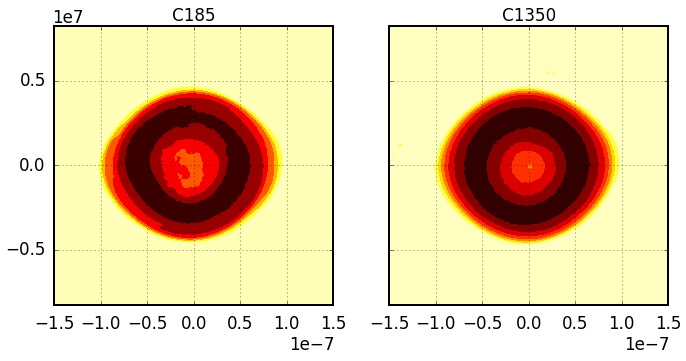

In [43]:
plot_c185_c1350_longphasespace(files_hollow[0])

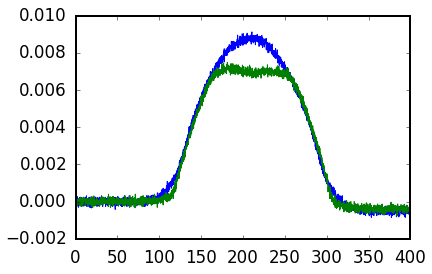

In [44]:
plt.plot(data_gauss['z_position'][1][0], data_gauss['z_profile'][1][0]*1.9/1.7)
plt.plot(data_hollow['z_position'][1][0], data_hollow['z_profile'][1][0])

20.9304634988
21.9860860413


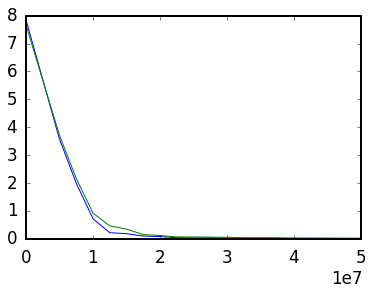

In [45]:
freqs = np.linspace(0, 1600/400e-9, 1601)
fft_gauss = savgol_filter(np.abs(np.fft.rfft(data_gauss['z_profile'][1][0])), 5, 1)
fft_hollow = savgol_filter(np.abs(np.fft.rfft(data_hollow['z_profile'][1][0])), 5, 1)
plt.plot(freqs, fft_gauss)
plt.plot(freqs, fft_hollow)
# plt.gca().set_yscale('log')
plt.xlim((0, 50e6))

print (np.sum(fft_gauss[:50]))
print (np.sum(fft_hollow[:50]))

## losses for bunch length scan

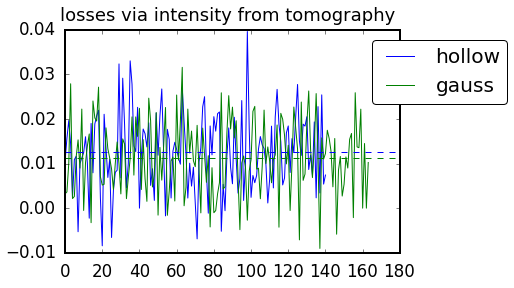

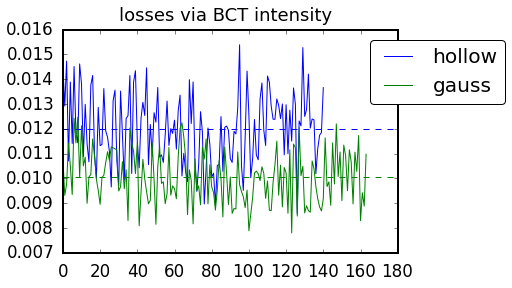

In [46]:
# intensity from tomography
losses_hollow_tomo = (data_hollow['eperimage'][0] - data_hollow['eperimage'][1]) / data_hollow['eperimage'][0]
losses_gauss_tomo = (data_gauss['eperimage'][0] - data_gauss['eperimage'][1]) / data_gauss['eperimage'][0]
plt.plot(losses_hollow_tomo, label='hollow', c='blue')
plt.plot(losses_gauss_tomo, label='gauss', c='green')
plt.axhline(np.mean(losses_hollow_tomo), c='blue', ls='--')
plt.axhline(np.mean(losses_gauss_tomo), c='green', ls='--')
plt.suptitle('losses via intensity from tomography', fontsize=18)
plt.legend(bbox_to_anchor=(1.35, 1));

# intensity from BCT
plt.figure()
plt.plot(data_hollow['losses'], label='hollow', c='blue')
plt.plot(data_gauss['losses'], label='gauss', c='green')
plt.axhline(np.mean(data_hollow['losses']), c='blue', ls='--')
plt.axhline(np.mean(data_gauss['losses']), c='green', ls='--')
plt.suptitle('losses via BCT intensity', fontsize=18)
plt.legend(bbox_to_anchor=(1.35, 1));

### interesting:
losses seem to be inaccessible to tomography: indication for losses outside of bucket, might be related to transfer of PSB to PS -- perhaps due to violent synchro which was set up differently for the two beams?

However: losses are w.r.t. C1350 and C185

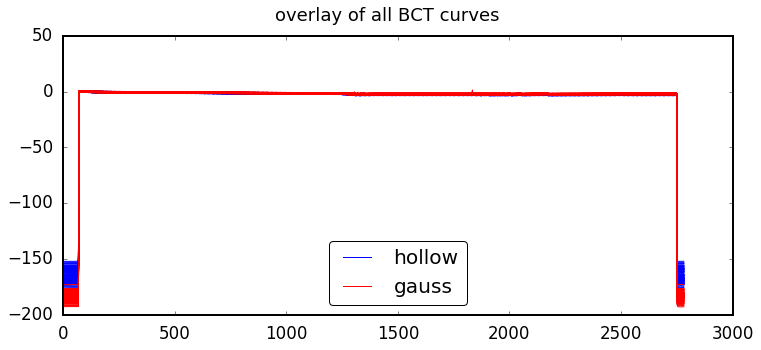

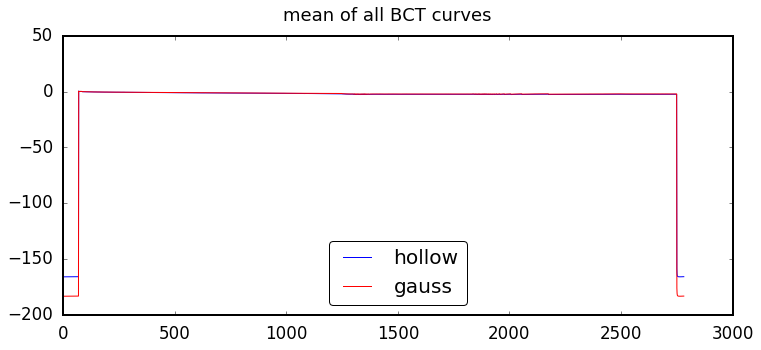

In [150]:
plt.figure(figsize=(12,5))
plt.suptitle('overlay of all BCT curves', fontsize=18)
label_done = False
for b in data_hollow['bct']:
    if not label_done:
        plt.plot(b - b[85], c='blue', label='hollow');
        label_done = True
    else:
        plt.plot(b - b[85], c='blue');

label_done = False
for b in data_gauss['bct']:
    if not label_done:
        plt.plot(b - b[85], c='red', label='gauss');
        label_done = True
    else:
        plt.plot(b - b[85], c='red');
plt.legend(loc=8);

plt.figure(figsize=(12,5))
plt.suptitle('mean of all BCT curves', fontsize=18)
losses_mean_hollow = np.mean(data_hollow['bct'], axis=0)
losses_mean_gauss = np.mean(data_gauss['bct'], axis=0)
plt.plot(losses_mean_hollow - losses_mean_hollow[85], c='blue', label='hollow')
plt.plot(losses_mean_gauss - losses_mean_gauss[85], c='red', label='gauss')
plt.legend(loc=8);

In [48]:
from operator import itemgetter

print ("hollow losses for averaged intensity curves and then divided: %.3f%%" %
        ((np.mean(map(itemgetter(85), data_hollow['bct'])) -
         np.mean(map(itemgetter(1250), data_hollow['bct']))) 
        / np.mean(map(itemgetter(85), data_hollow['bct'])) * 100)
       )

print (" Gauss losses for averaged intensity curves and then divided: %.3f%%" %
        ((np.mean(map(itemgetter(85), data_gauss['bct'])) - 
         np.mean(map(itemgetter(1250), data_gauss['bct']))) 
        / np.mean(map(itemgetter(85), data_gauss['bct'])) * 100)
       )

hollow losses for averaged intensity curves and then divided: 1.187%
 Gauss losses for averaged intensity curves and then divided: 0.977%


Losses are slightly different but both in a negligible regime, they also also seem unrelated to the bunch length scanning.